# Imports

In [246]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno



from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor 
import lightgbm as lgb 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline

import holidays
from datetime import datetime

%matplotlib inline

# Import and Merge DataFrames

In [2]:
df_features = pd.read_csv('data/sales_features.csv', index_col=0)
df_pred = pd.read_csv('data/sales_pred.csv', index_col=0)
df_stores = pd.read_csv('data/sales_stores.csv', index_col=0)

In [3]:
df_features

,Store,Date,Temperature
0,1,2010-02-05,64.51
1,1,2010-02-12,47.21
2,1,2010-02-19,48.84
3,1,2010-02-26,77.31
4,1,2010-03-05,68.32
...,...,...,...
8185,45,2013-06-28,72.26
8186,45,2013-07-05,73.20
8187,45,2013-07-12,60.12
8188,45,2013-07-19,35.73


In [4]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8190 entries, 0 to 8189
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Store        8190 non-null   int64  
 1   Date         8190 non-null   object 
 2   Temperature  8190 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 255.9+ KB


In [5]:
#Since other dataframes use lower case we changed each feature name to lowecase
cols = df_features.columns.tolist()
cols = [col.lower() for col in df_features.columns]
df_features.columns = cols 
df_features

,store,date,temperature
0,1,2010-02-05,64.51
1,1,2010-02-12,47.21
2,1,2010-02-19,48.84
3,1,2010-02-26,77.31
4,1,2010-03-05,68.32
...,...,...,...
8185,45,2013-06-28,72.26
8186,45,2013-07-05,73.20
8187,45,2013-07-12,60.12
8188,45,2013-07-19,35.73


In [6]:
df_pred

,store,departments,date,weekly_sales
0,1,12,2010-02-05,39334.454177
1,1,65,2010-02-12,3031.702745
2,1,3,2010-02-19,7189.807789
3,1,27,2010-02-26,15113.581397
4,1,82,2010-03-05,37268.618413
...,...,...,...,...
421565,45,99,2012-09-28,10356.329581
421566,45,34,2012-10-05,2816.671249
421567,45,10,2012-10-12,44144.658122
421568,45,88,2012-10-19,60597.320304


In [7]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 421569
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         421570 non-null  int64  
 1   departments   421570 non-null  int64  
 2   date          421570 non-null  object 
 3   weekly_sales  421570 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 16.1+ MB


In [8]:
df_stores

,store,sale_type,size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


Merge dataframes with using primary keys

In [9]:
merged_df = pd.merge(df_pred, df_features, on=['store', 'date'], how='left')

merged_df

,store,departments,date,weekly_sales,temperature
0,1,12,2010-02-05,39334.454177,64.51
1,1,65,2010-02-12,3031.702745,47.21
2,1,3,2010-02-19,7189.807789,48.84
3,1,27,2010-02-26,15113.581397,77.31
4,1,82,2010-03-05,37268.618413,68.32
...,...,...,...,...,...
421565,45,99,2012-09-28,10356.329581,50.86
421566,45,34,2012-10-05,2816.671249,58.53
421567,45,10,2012-10-12,44144.658122,70.38
421568,45,88,2012-10-19,60597.320304,50.26


In [10]:
df = pd.merge(merged_df, df_stores, on='store', how='left')
df 

,store,departments,date,weekly_sales,temperature,sale_type,size
0,1,12,2010-02-05,39334.454177,64.51,A,151315
1,1,65,2010-02-12,3031.702745,47.21,A,151315
2,1,3,2010-02-19,7189.807789,48.84,A,151315
3,1,27,2010-02-26,15113.581397,77.31,A,151315
4,1,82,2010-03-05,37268.618413,68.32,A,151315
...,...,...,...,...,...,...,...
421565,45,99,2012-09-28,10356.329581,50.86,B,118221
421566,45,34,2012-10-05,2816.671249,58.53,B,118221
421567,45,10,2012-10-12,44144.658122,70.38,B,118221
421568,45,88,2012-10-19,60597.320304,50.26,B,118221


In [11]:
df['sale_type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [12]:
#Check for null and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         421570 non-null  int64  
 1   departments   421570 non-null  int64  
 2   date          421570 non-null  object 
 3   weekly_sales  421570 non-null  float64
 4   temperature   421570 non-null  float64
 5   sale_type     421570 non-null  object 
 6   size          421570 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 22.5+ MB


In [13]:
df.isnull().sum()

store           0
departments     0
date            0
weekly_sales    0
temperature     0
sale_type       0
size            0
dtype: int64

<Axes: >

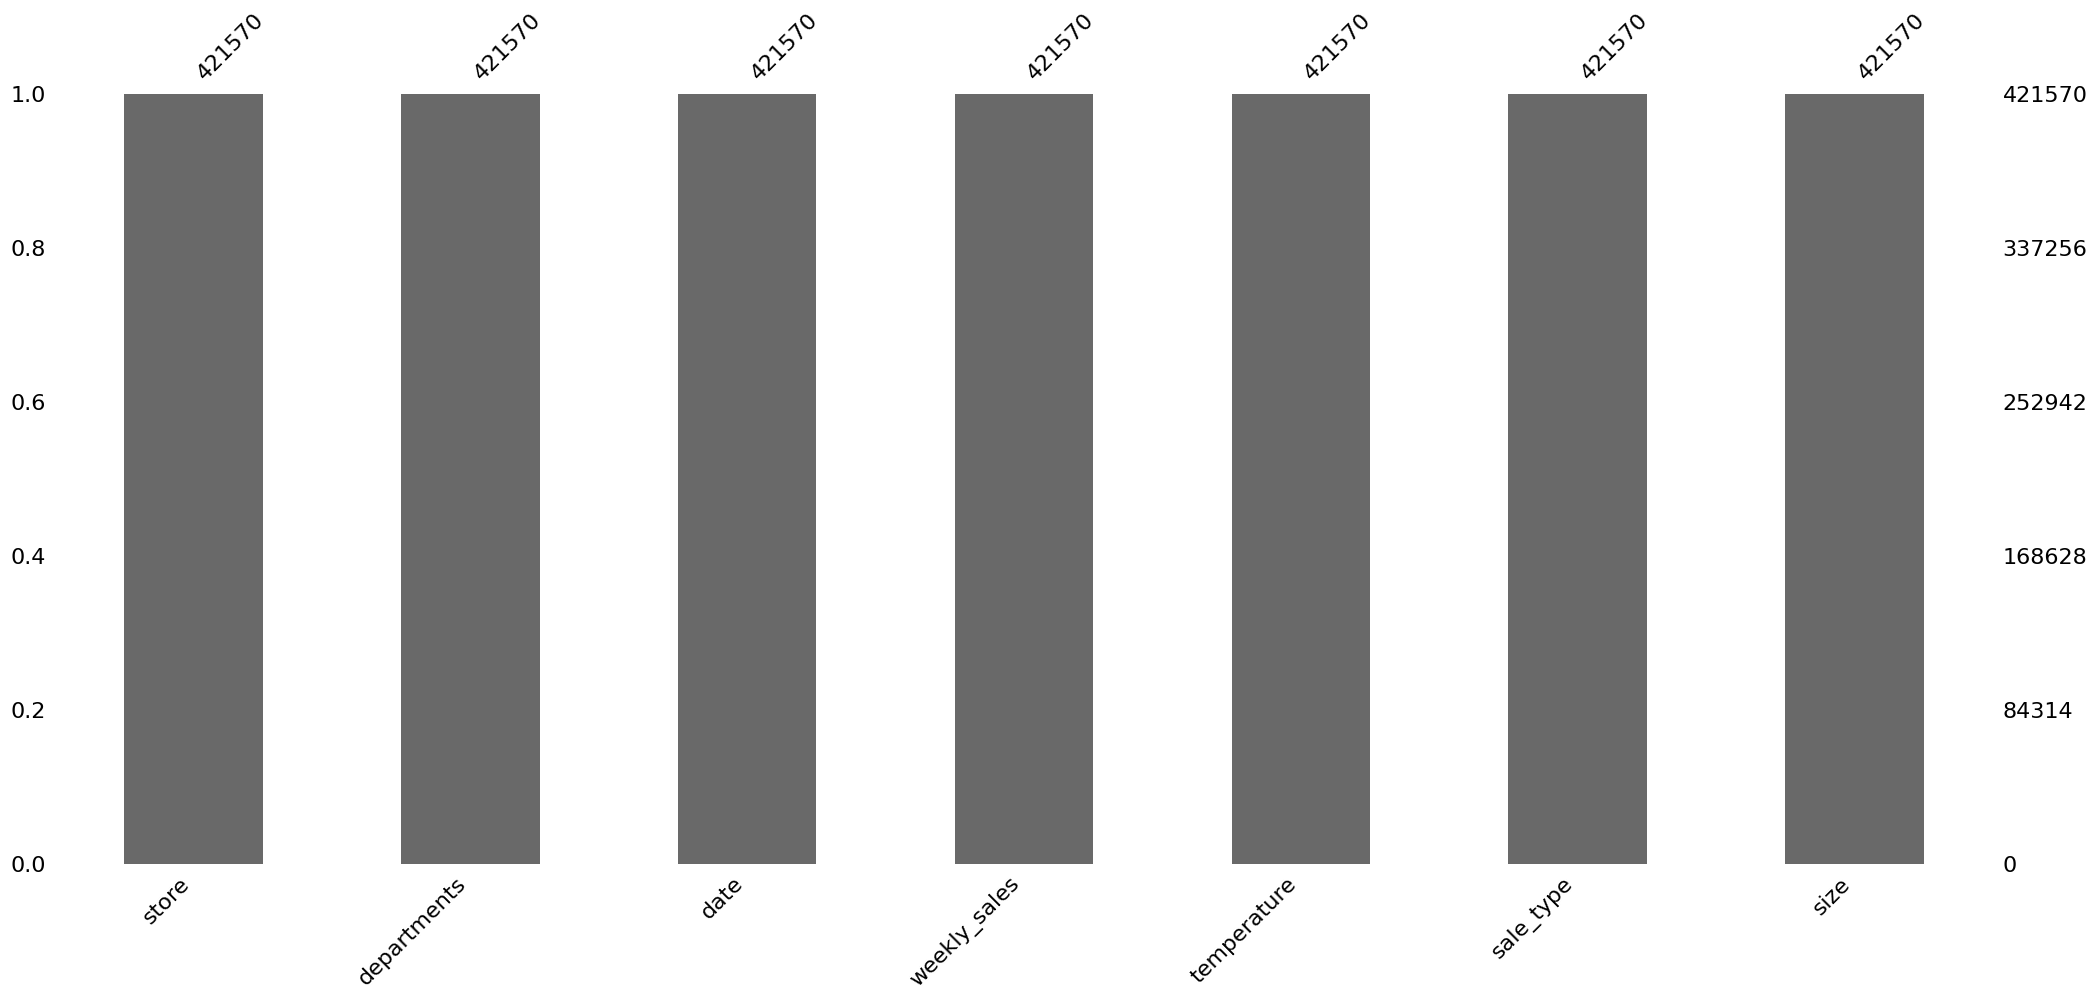

In [14]:
#Check for missing values
msno.bar(df)

In [15]:
df['store'].nunique()

45

In [16]:
df['departments'].nunique()

99

In [17]:
# Make date column to datetime dtype
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store         421570 non-null  int64         
 1   departments   421570 non-null  int64         
 2   date          421570 non-null  datetime64[ns]
 3   weekly_sales  421570 non-null  float64       
 4   temperature   421570 non-null  float64       
 5   sale_type     421570 non-null  object        
 6   size          421570 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 22.5+ MB


# EDA

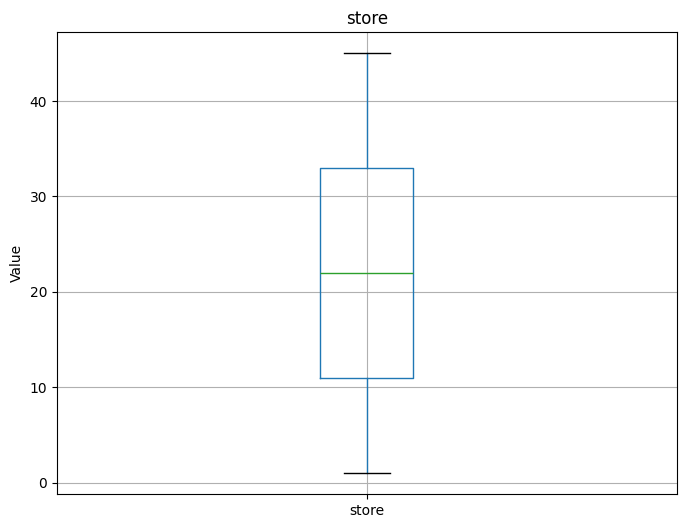

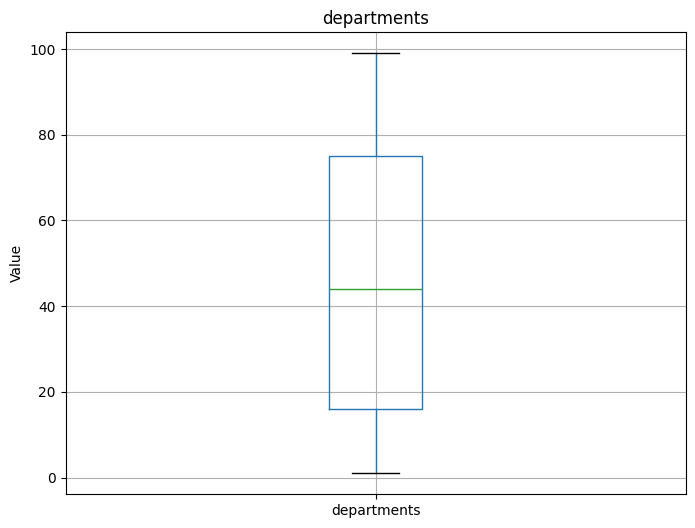

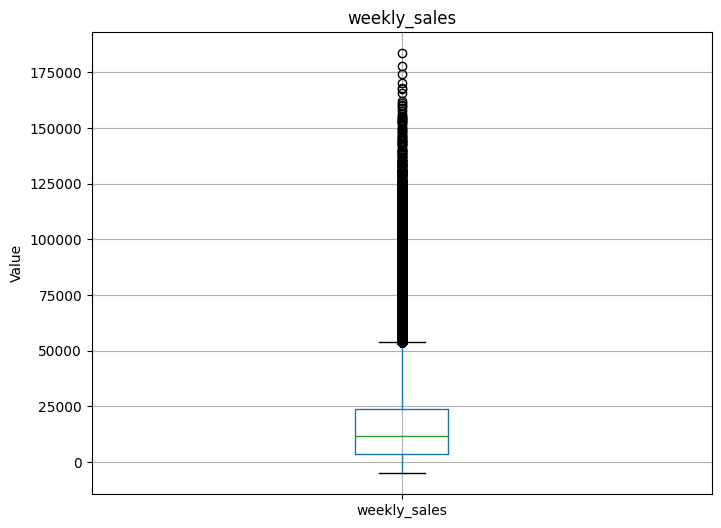

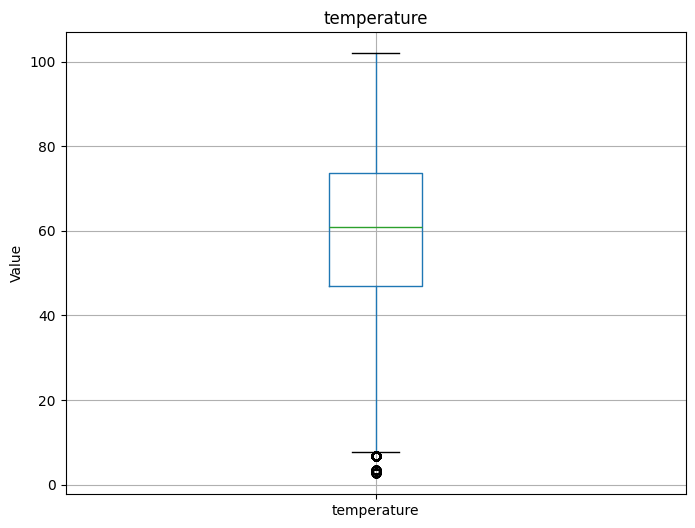

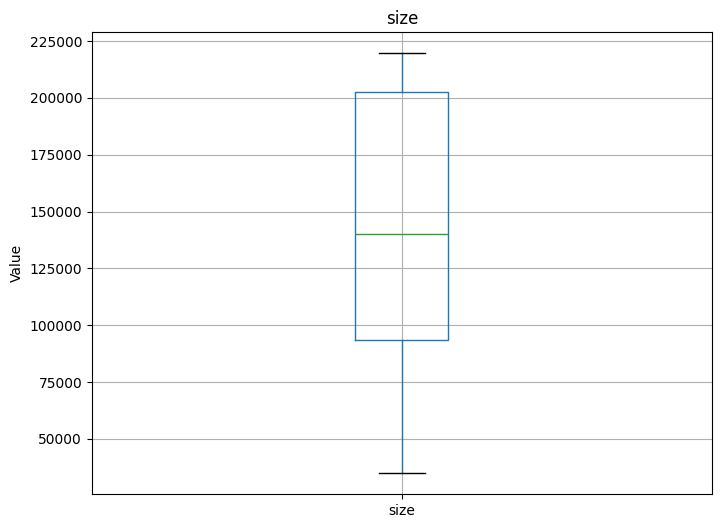

In [18]:
# Check for outliers 

numerical_cols = df.select_dtypes(include=['float64', 'int64'])

for column in numerical_cols.columns:
    plt.figure(figsize=(8,6))
    df.boxplot(column=[column])
    plt.title(f'{column}')
    plt.ylabel('Value')
    plt.show()

In [19]:
df

,store,departments,date,weekly_sales,temperature,sale_type,size
0,1,12,2010-02-05,39334.454177,64.51,A,151315
1,1,65,2010-02-12,3031.702745,47.21,A,151315
2,1,3,2010-02-19,7189.807789,48.84,A,151315
3,1,27,2010-02-26,15113.581397,77.31,A,151315
4,1,82,2010-03-05,37268.618413,68.32,A,151315
...,...,...,...,...,...,...,...
421565,45,99,2012-09-28,10356.329581,50.86,B,118221
421566,45,34,2012-10-05,2816.671249,58.53,B,118221
421567,45,10,2012-10-12,44144.658122,70.38,B,118221
421568,45,88,2012-10-19,60597.320304,50.26,B,118221


In [20]:
df.loc[df['weekly_sales'] < 0]

,store,departments,date,weekly_sales,temperature,sale_type,size
11,1,43,2010-04-23,-907.206030,14.17,A,151315
12,1,12,2010-04-30,-552.895741,49.05,A,151315
14,1,91,2010-05-14,-3324.697712,93.36,A,151315
19,1,23,2010-06-18,-2682.814276,76.14,A,151315
20,1,74,2010-06-25,-849.438631,66.25,A,151315
...,...,...,...,...,...,...,...
421521,45,82,2011-11-25,-988.292614,32.68,B,118221
421542,45,24,2012-04-20,-121.296823,71.04,B,118221
421556,45,7,2012-07-27,-3188.962110,51.18,B,118221
421559,45,3,2012-08-17,-4003.133336,54.53,B,118221


In [21]:
#Percentage of minus weekly sales 
pct_weekly_minus = (54617/421570)*100
print('Percentage of minus weekly sale is:', pct_weekly_minus)

Percentage of minus weekly sale is: 12.955618284033493


In [22]:
#Delete negative values

df = df.loc[df['weekly_sales'] > 0]

In [23]:
df.loc[df['weekly_sales'] < 0] # Now we don't have any negative values in our dataset

,store,departments,date,weekly_sales,temperature,sale_type,size


In [24]:
df.sort_values(by='date')

,store,departments,date,weekly_sales,temperature,sale_type,size
0,1,12,2010-02-05,39334.454177,64.51,A,151315
282589,29,67,2010-02-05,15892.350896,57.67,B,93638
75472,8,87,2010-02-05,10474.579718,70.62,A,155078
282440,29,48,2010-02-05,36743.967477,57.67,B,93638
183243,19,84,2010-02-05,21281.329379,67.72,A,203819
...,...,...,...,...,...,...,...
228155,24,83,2012-10-26,8437.171997,89.03,A,203819
228012,24,26,2012-10-26,5606.978221,89.03,A,203819
336330,35,96,2012-10-26,34273.739877,69.46,B,103681
106136,11,3,2012-10-26,37139.696117,65.01,A,207499


Our date range is 2010.02.05 - 2012.10.26

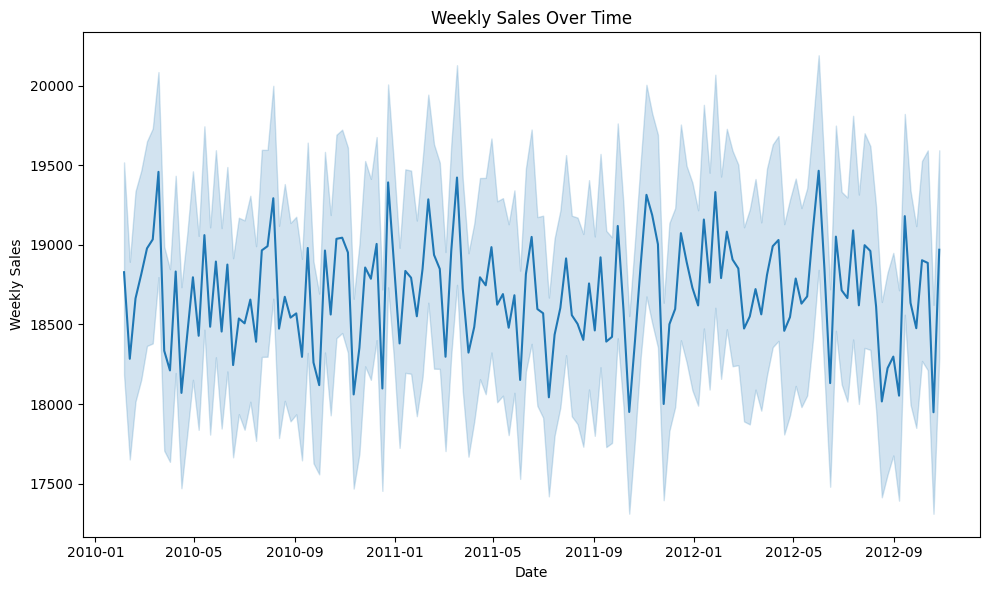

In [25]:
#Weekly Sales vs Date
plt.figure(figsize=(10, 6))


sns.lineplot(data=df, x='date', y='weekly_sales')

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')

plt.tight_layout()
plt.show()

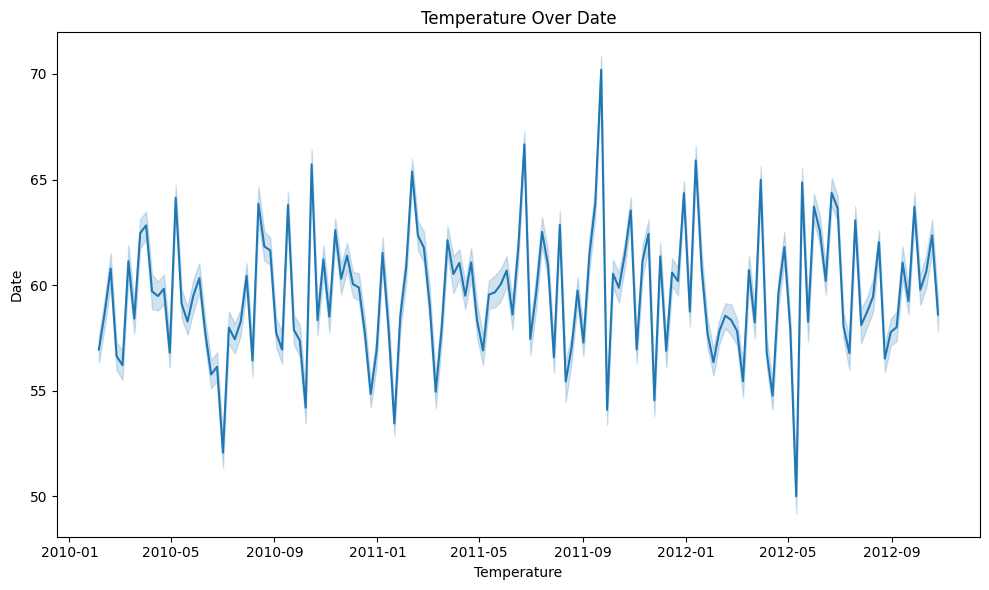

In [26]:
#Temperature vs Date
plt.figure(figsize=(10, 6))


sns.lineplot(data=df, x='date', y='temperature')

plt.xlabel('Temperature')
plt.ylabel('Date')
plt.title('Temperature Over Date')

plt.tight_layout()
plt.show()

In [27]:
sales_by_store = df.groupby('store').count()['weekly_sales']
sales_by_store

store
1     8872
2     8905
3     7858
4     8934
5     7890
6     8853
7     8538
8     8597
9     7765
10    8939
11    8741
12    8464
13    9106
14    8792
15    8593
16    8185
17    8623
18    8598
19    8850
20    8904
21    8371
22    8406
23    8701
24    8914
25    8511
26    8588
27    8957
28    8845
29    8204
30    6207
31    8765
32    8835
33    5598
34    8881
35    8281
36    5458
37    6277
38    6451
39    8614
40    8765
41    8807
42    6061
43    5896
44    6213
45    8340
Name: weekly_sales, dtype: int64

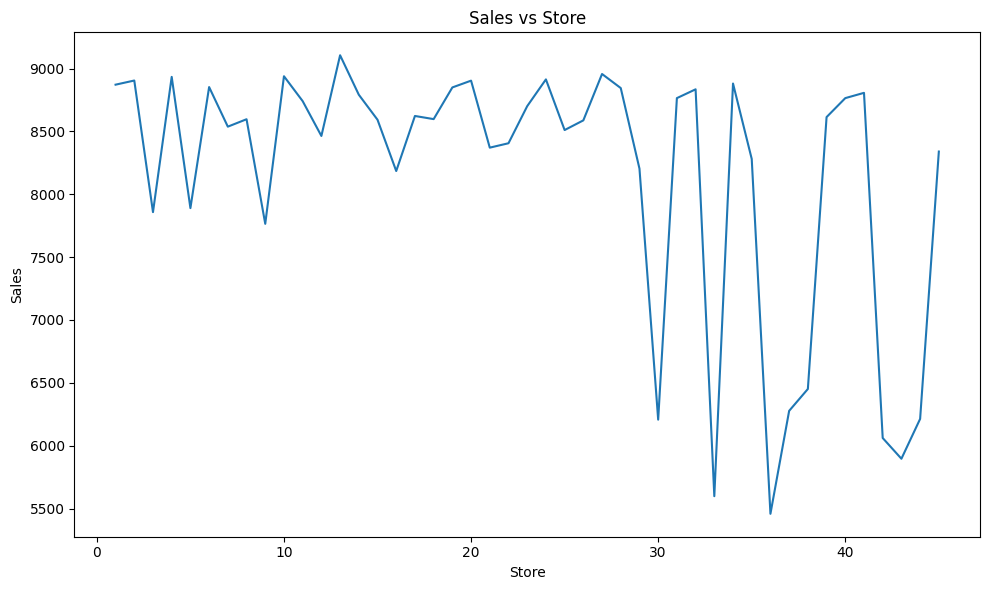

In [28]:
# Sale vs Store
plt.figure(figsize=(10, 6))

sns.lineplot(data=sales_by_store)

plt.xlabel('Store')
plt.ylabel('Sales')
plt.title('Sales vs Store')

plt.tight_layout()
plt.show()

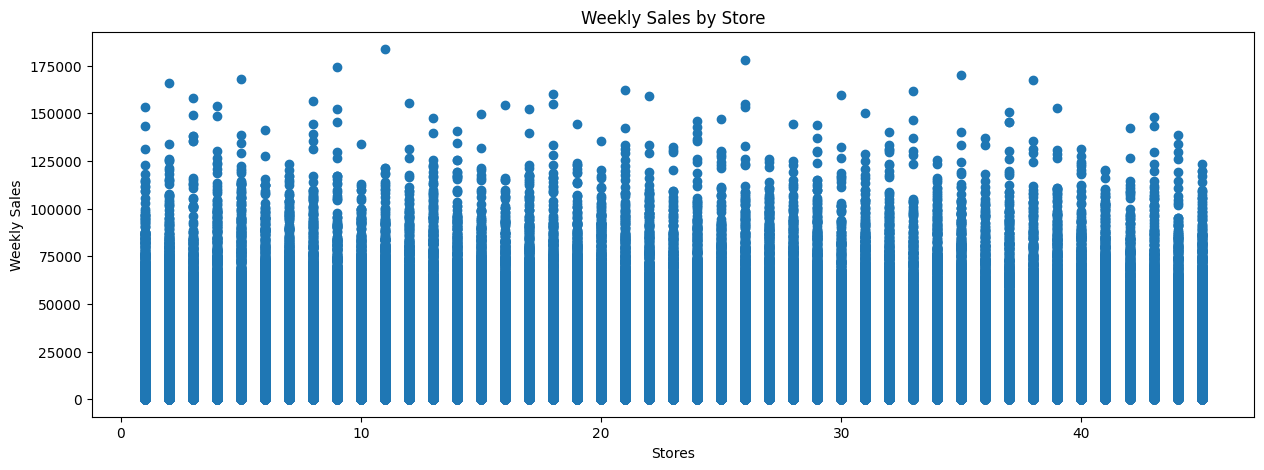

In [29]:
x = df['store']
y = df['weekly_sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

In [30]:
sales_by_department = df.groupby('departments').count()['weekly_sales']
sales_by_department

departments
1      7519
2     11888
3      8381
4      7109
5      6386
      ...  
95     4450
96     4925
97     5318
98     6553
99     5417
Name: weekly_sales, Length: 99, dtype: int64

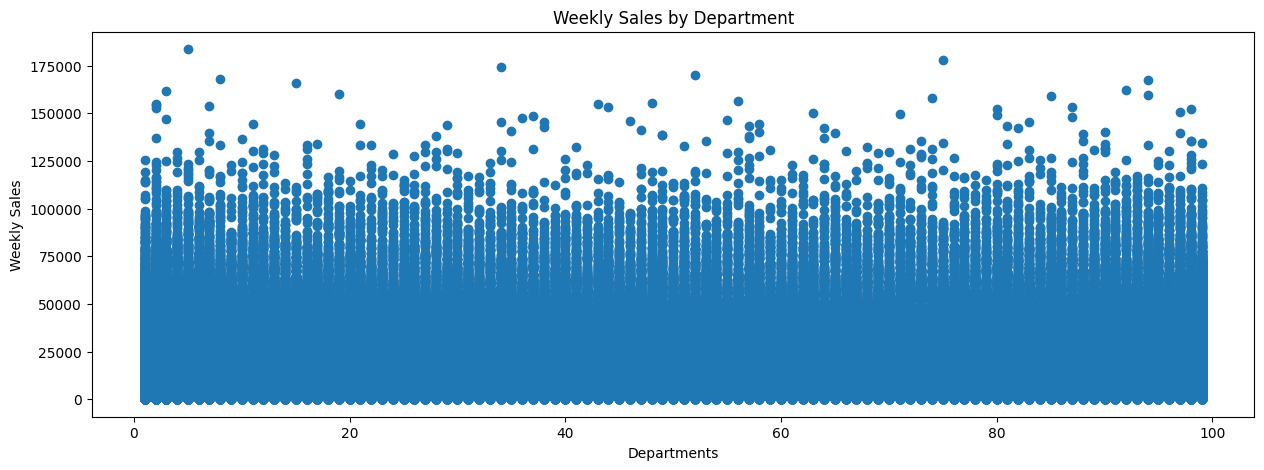

In [31]:
# Sale vs Department
x = df['departments']
y = df['weekly_sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

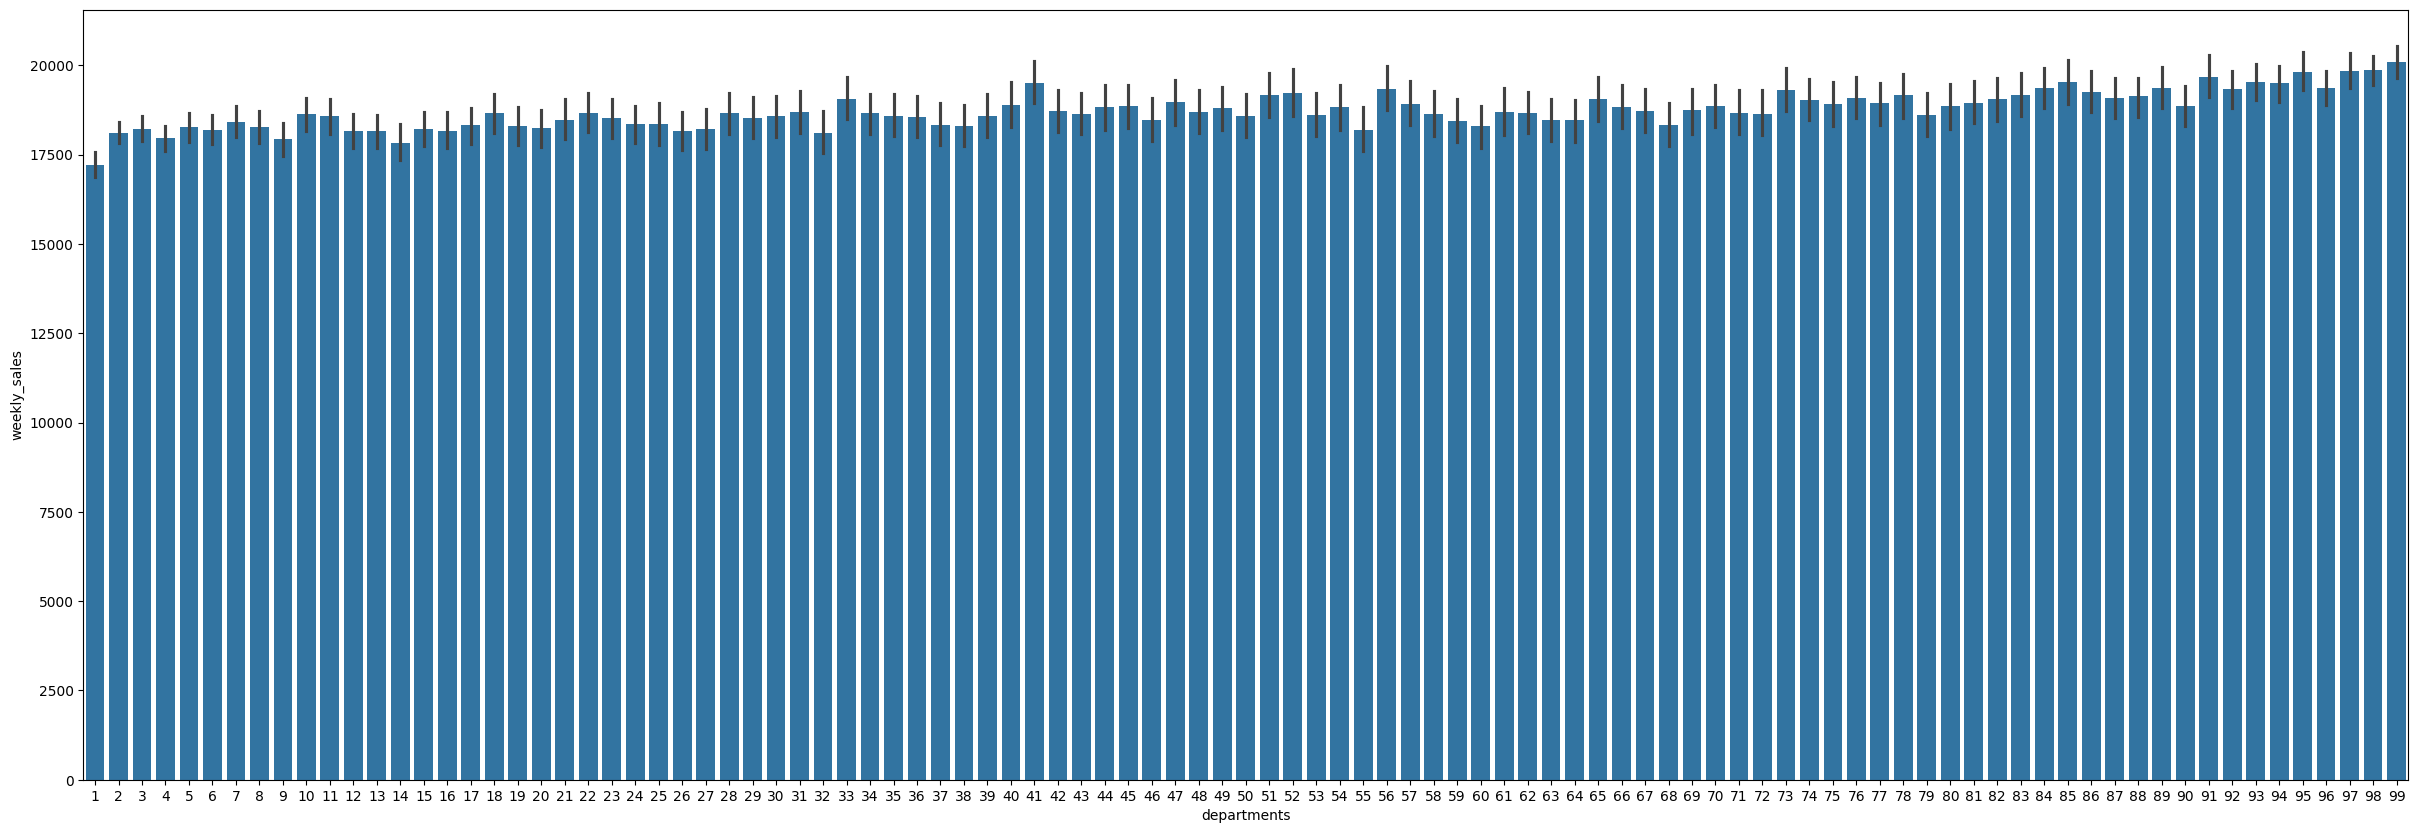

In [32]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='departments', y='weekly_sales', data=df)

In [33]:
temp_df = df.groupby('temperature')['weekly_sales'].mean()

In [34]:
temp_df

temperature
2.69      17143.211744
3.52      17826.276808
6.76      18305.214391
6.80      20798.912772
6.84      22557.309487
              ...     
99.04     18747.486706
99.14     15146.609930
99.87     20224.131699
100.73    17494.630067
101.95    21532.653253
Name: weekly_sales, Length: 4167, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


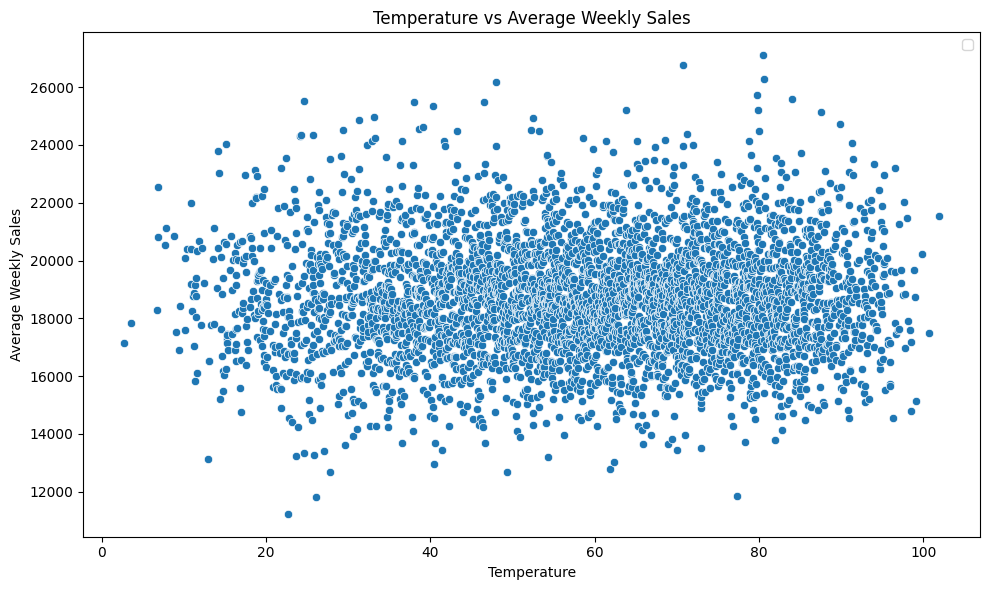

In [35]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=temp_df)

plt.xlabel('Temperature')
plt.ylabel('Average Weekly Sales')
plt.title('Temperature vs Average Weekly Sales')

plt.legend()
plt.tight_layout()
plt.show()

In [36]:
df.describe()

,store,departments,date,weekly_sales,temperature,size
count,366953.000000,366953.000000,366953,366953.000000,366953.000000,366953.000000
mean,22.200936,46.289827,2011-06-18 07:24:55.604069376,18697.101818,59.602963,136720.938750
min,1.000000,1.000000,2010-02-05 00:00:00,0.030945,2.690000,34875.000000
25%,11.000000,16.000000,2010-10-08 00:00:00,6445.161967,46.900000,93638.000000
50%,22.000000,44.000000,2011-06-17 00:00:00,14126.866967,60.930000,140167.000000
75%,33.000000,75.000000,2012-02-24 00:00:00,26017.605763,73.560000,202505.000000
max,45.000000,99.000000,2012-10-26 00:00:00,183553.488334,101.950000,219622.000000
std,12.784390,31.760888,NaN,16744.293793,18.507811,60997.837125


In [37]:
sales_by_size = df.groupby('size').count()['weekly_sales']

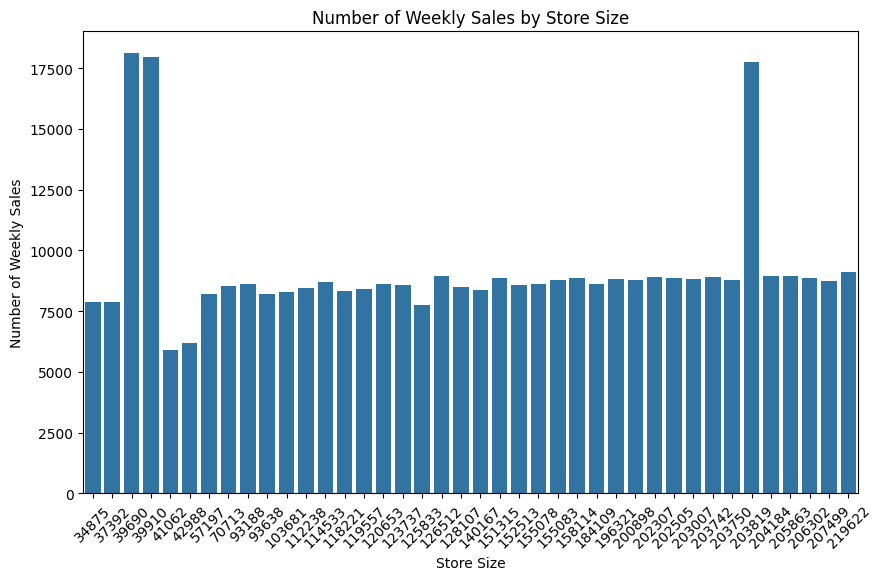

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_size.index, y=sales_by_size.values)
plt.xlabel('Store Size')
plt.ylabel('Number of Weekly Sales')
plt.title('Number of Weekly Sales by Store Size')
plt.xticks(rotation=45)
plt.show()

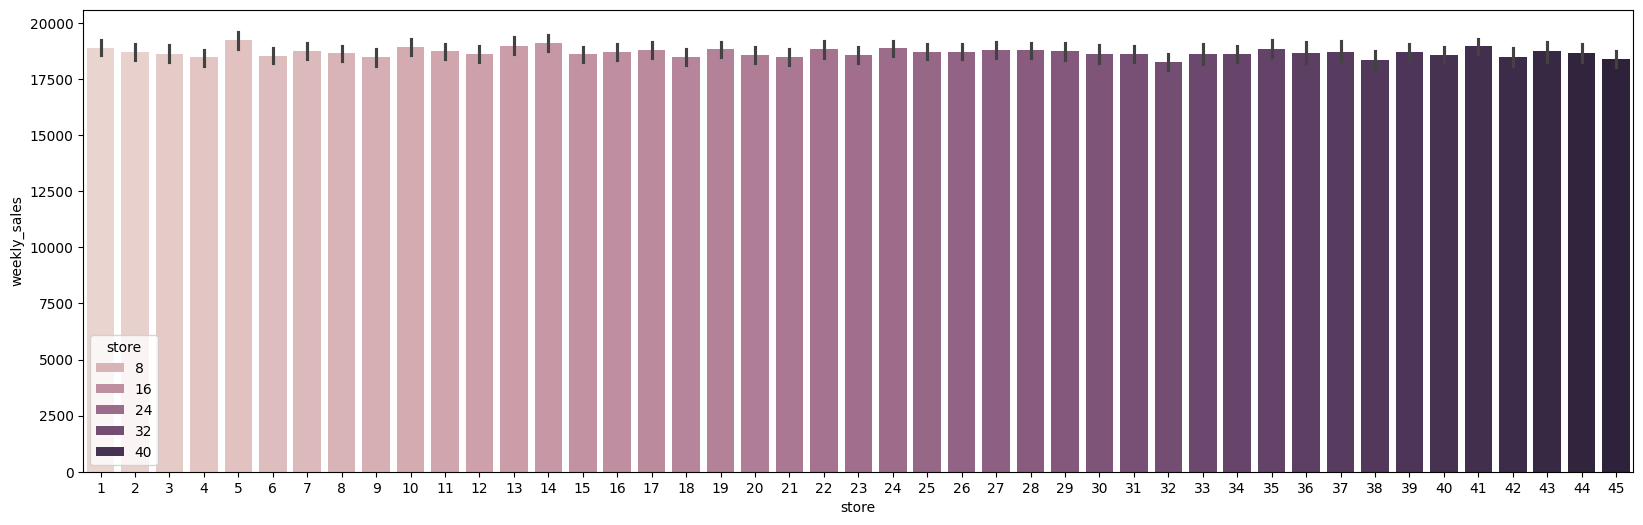

In [39]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='store', y='weekly_sales',hue='store', data=df)

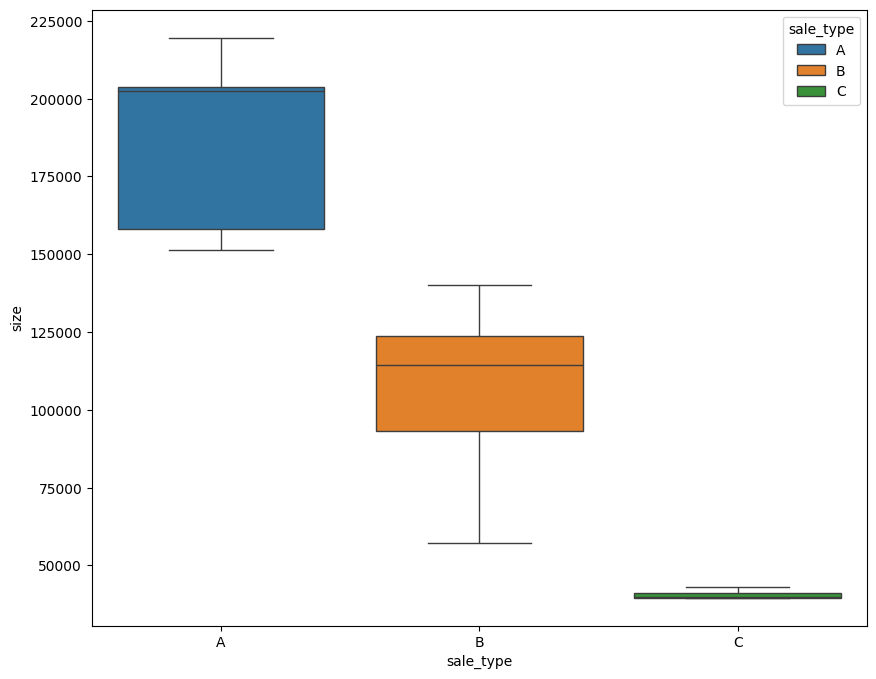

In [40]:
plt.figure(figsize=(10,8))
fig = sns.boxplot(x='sale_type', y='size',data=df,hue='sale_type' ,showfliers=False, legend="brief")

We can see that Store Type A is the biggest one and Type C is the smallest one. Logically that should affact the sales since bigger stores has more potential for weekly sale

In [41]:
#Separate date to create new features 

df['week'] =df['date'].dt.isocalendar().week
df['month'] =df['date'].dt.month 
df['year'] =df['date'].dt.year

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366953 entries, 0 to 421569
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store         366953 non-null  int64         
 1   departments   366953 non-null  int64         
 2   date          366953 non-null  datetime64[ns]
 3   weekly_sales  366953 non-null  float64       
 4   temperature   366953 non-null  float64       
 5   sale_type     366953 non-null  object        
 6   size          366953 non-null  int64         
 7   week          366953 non-null  UInt32        
 8   month         366953 non-null  int32         
 9   year          366953 non-null  int32         
dtypes: UInt32(1), datetime64[ns](1), float64(2), int32(2), int64(3), object(1)
memory usage: 26.9+ MB


/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/2918244580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week'] =df['date'].dt.isocalendar().week
/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/2918244580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] =df['date'].dt.month
/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/2918244580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [42]:
#For the consistency in dtypes need to change dtype of week
df['week'] = df['week'].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366953 entries, 0 to 421569
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store         366953 non-null  int64         
 1   departments   366953 non-null  int64         
 2   date          366953 non-null  datetime64[ns]
 3   weekly_sales  366953 non-null  float64       
 4   temperature   366953 non-null  float64       
 5   sale_type     366953 non-null  object        
 6   size          366953 non-null  int64         
 7   week          366953 non-null  int32         
 8   month         366953 non-null  int32         
 9   year          366953 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(3), object(1)
memory usage: 26.6+ MB


/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/2755616745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week'] = df['week'].astype('int32')


Text(0.5, 1.0, 'Monthly Sales Patterns by Year')

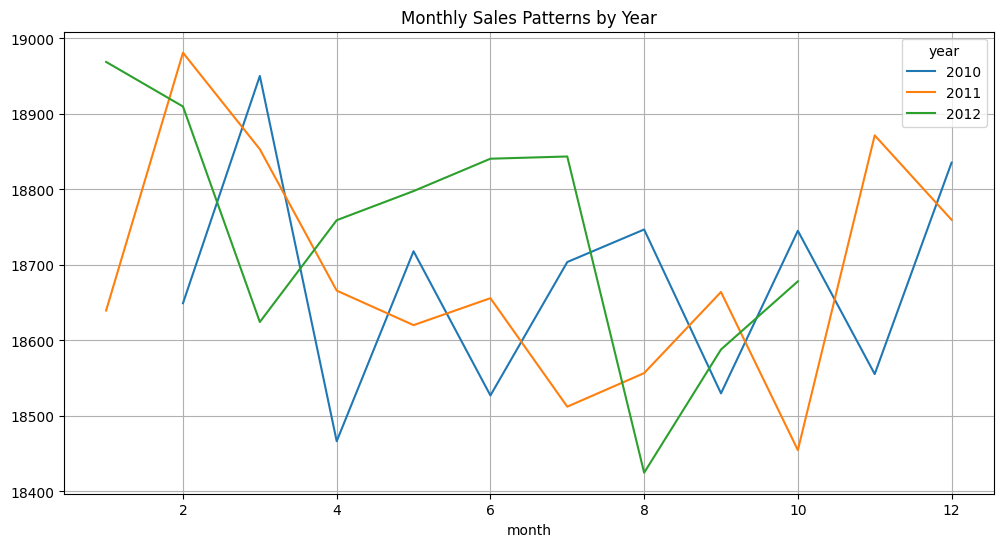

In [43]:
# Check for pattern around month
monthly_sales = pd.pivot_table(df, values = 'weekly_sales', columns = 'year', index = 'month')
ax = monthly_sales.plot(figsize=(12, 6), grid=True)
ax.set_title('Monthly Sales Patterns by Year')

Text(0.5, 1.0, 'Weekly Sales Patterns by Year')

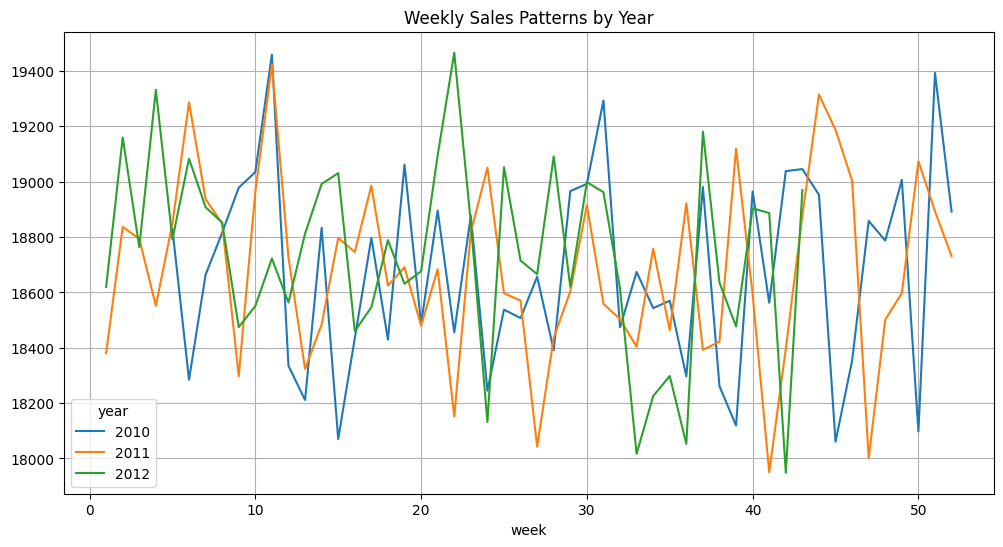

In [44]:
weekly_sales = pd.pivot_table(df, values = "weekly_sales", columns = "year", index = "week")
ax = weekly_sales.plot(figsize=(12, 6), grid=True)
ax.set_title('Weekly Sales Patterns by Year')

Need to encode sale type then model can understand from data

In [45]:
sale_type = {'A':1, 'B':2, 'C':3}
df['sale_type'] = df['sale_type'].replace(sale_type)

/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/3031622813.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sale_type'] = df['sale_type'].replace(sale_type)
/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/3031622813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sale_type'] = df['sale_type'].replace(sale_type)


In [46]:
df

,store,departments,date,weekly_sales,temperature,sale_type,size,week,month,year
0,1,12,2010-02-05,39334.454177,64.51,1,151315,5,2,2010
1,1,65,2010-02-12,3031.702745,47.21,1,151315,6,2,2010
2,1,3,2010-02-19,7189.807789,48.84,1,151315,7,2,2010
3,1,27,2010-02-26,15113.581397,77.31,1,151315,8,2,2010
4,1,82,2010-03-05,37268.618413,68.32,1,151315,9,3,2010
...,...,...,...,...,...,...,...,...,...,...
421565,45,99,2012-09-28,10356.329581,50.86,2,118221,39,9,2012
421566,45,34,2012-10-05,2816.671249,58.53,2,118221,40,10,2012
421567,45,10,2012-10-12,44144.658122,70.38,2,118221,41,10,2012
421568,45,88,2012-10-19,60597.320304,50.26,2,118221,42,10,2012


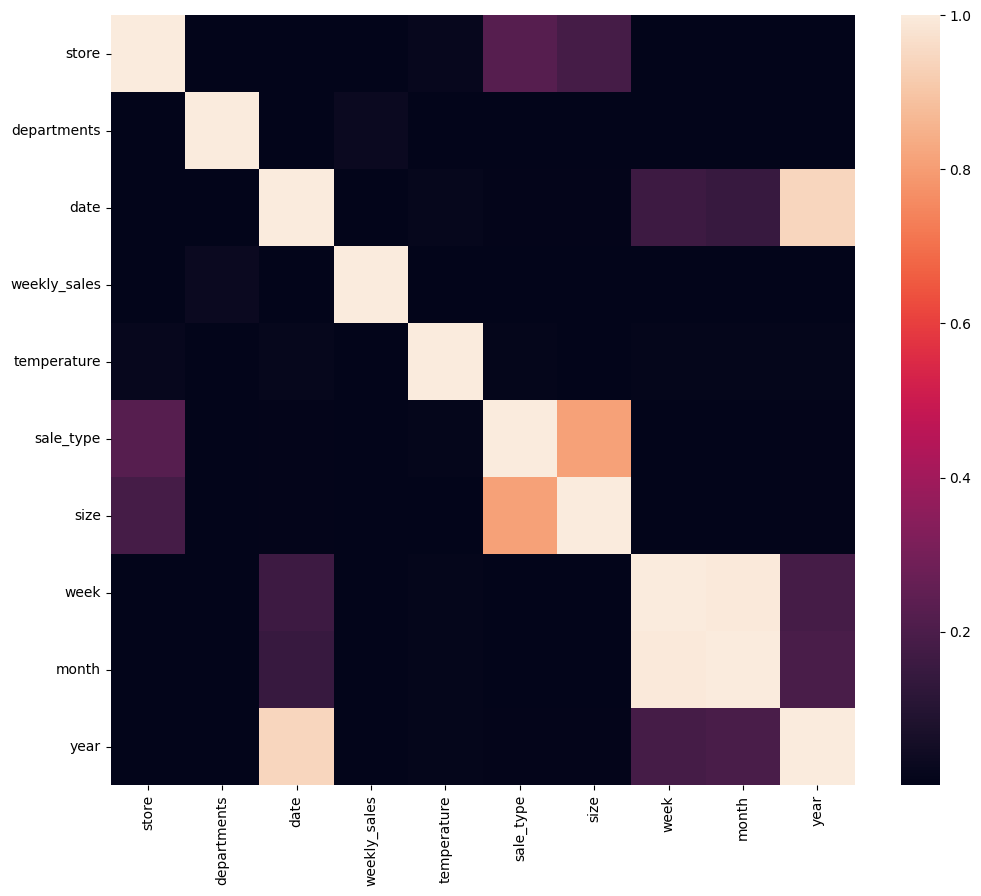

In [47]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    # To see the correlations
plt.show()

In [48]:
df

,store,departments,date,weekly_sales,temperature,sale_type,size,week,month,year
0,1,12,2010-02-05,39334.454177,64.51,1,151315,5,2,2010
1,1,65,2010-02-12,3031.702745,47.21,1,151315,6,2,2010
2,1,3,2010-02-19,7189.807789,48.84,1,151315,7,2,2010
3,1,27,2010-02-26,15113.581397,77.31,1,151315,8,2,2010
4,1,82,2010-03-05,37268.618413,68.32,1,151315,9,3,2010
...,...,...,...,...,...,...,...,...,...,...
421565,45,99,2012-09-28,10356.329581,50.86,2,118221,39,9,2012
421566,45,34,2012-10-05,2816.671249,58.53,2,118221,40,10,2012
421567,45,10,2012-10-12,44144.658122,70.38,2,118221,41,10,2012
421568,45,88,2012-10-19,60597.320304,50.26,2,118221,42,10,2012


In [49]:
df = df.sort_values(by='date', ascending=True)
df

,store,departments,date,weekly_sales,temperature,sale_type,size,week,month,year
0,1,12,2010-02-05,39334.454177,64.51,1,151315,5,2,2010
282589,29,67,2010-02-05,15892.350896,57.67,2,93638,5,2,2010
75472,8,87,2010-02-05,10474.579718,70.62,1,155078,5,2,2010
282440,29,48,2010-02-05,36743.967477,57.67,2,93638,5,2,2010
183243,19,84,2010-02-05,21281.329379,67.72,1,203819,5,2,2010
...,...,...,...,...,...,...,...,...,...,...
228155,24,83,2012-10-26,8437.171997,89.03,1,203819,43,10,2012
228012,24,26,2012-10-26,5606.978221,89.03,1,203819,43,10,2012
336330,35,96,2012-10-26,34273.739877,69.46,2,103681,43,10,2012
106136,11,3,2012-10-26,37139.696117,65.01,1,207499,43,10,2012


In [50]:
df_model = df.copy()
df_model

,store,departments,date,weekly_sales,temperature,sale_type,size,week,month,year
0,1,12,2010-02-05,39334.454177,64.51,1,151315,5,2,2010
282589,29,67,2010-02-05,15892.350896,57.67,2,93638,5,2,2010
75472,8,87,2010-02-05,10474.579718,70.62,1,155078,5,2,2010
282440,29,48,2010-02-05,36743.967477,57.67,2,93638,5,2,2010
183243,19,84,2010-02-05,21281.329379,67.72,1,203819,5,2,2010
...,...,...,...,...,...,...,...,...,...,...
228155,24,83,2012-10-26,8437.171997,89.03,1,203819,43,10,2012
228012,24,26,2012-10-26,5606.978221,89.03,1,203819,43,10,2012
336330,35,96,2012-10-26,34273.739877,69.46,2,103681,43,10,2012
106136,11,3,2012-10-26,37139.696117,65.01,1,207499,43,10,2012


In [51]:
df_model= df_model.drop(['date'], axis=1)

In [52]:
df_model

,store,departments,weekly_sales,temperature,sale_type,size,week,month,year
0,1,12,39334.454177,64.51,1,151315,5,2,2010
282589,29,67,15892.350896,57.67,2,93638,5,2,2010
75472,8,87,10474.579718,70.62,1,155078,5,2,2010
282440,29,48,36743.967477,57.67,2,93638,5,2,2010
183243,19,84,21281.329379,67.72,1,203819,5,2,2010
...,...,...,...,...,...,...,...,...,...
228155,24,83,8437.171997,89.03,1,203819,43,10,2012
228012,24,26,5606.978221,89.03,1,203819,43,10,2012
336330,35,96,34273.739877,69.46,2,103681,43,10,2012
106136,11,3,37139.696117,65.01,1,207499,43,10,2012


Since temperature data is too noisy and no significant affact on target we will drop 

In [53]:
df_model= df_model.drop(['temperature'], axis=1)

In [54]:
df_model

,store,departments,weekly_sales,sale_type,size,week,month,year
0,1,12,39334.454177,1,151315,5,2,2010
282589,29,67,15892.350896,2,93638,5,2,2010
75472,8,87,10474.579718,1,155078,5,2,2010
282440,29,48,36743.967477,2,93638,5,2,2010
183243,19,84,21281.329379,1,203819,5,2,2010
...,...,...,...,...,...,...,...,...
228155,24,83,8437.171997,1,203819,43,10,2012
228012,24,26,5606.978221,1,203819,43,10,2012
336330,35,96,34273.739877,2,103681,43,10,2012
106136,11,3,37139.696117,1,207499,43,10,2012


# Modeling 

Train - Test Split - 70% Train | 30% Test 

In [55]:
train_df = df_model.iloc[:int(0.7 * len(df_model))]
test_df = df_model.iloc[int(0.7 * len(df_model)):]

In [56]:
train_df.shape

(256867, 8)

In [57]:
test_df.shape

(110086, 8)

In [58]:
target = ['weekly_sales']

features = [c for c in df_model.columns.to_list() if c not in target]

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape )
print('Shape of y_train',y_train.shape )
print('Shape of y_test', y_test.shape)

Shape of X_train (256867, 7)
Shape of X_test (110086, 7)
Shape of y_train (256867, 1)
Shape of y_test (110086, 1)


In [59]:
X_train

,store,departments,sale_type,size,week,month,year
0,1,12,1,151315,5,2,2010
282589,29,67,2,93638,5,2,2010
75472,8,87,1,155078,5,2,2010
282440,29,48,2,93638,5,2,2010
183243,19,84,1,203819,5,2,2010
...,...,...,...,...,...,...,...
207660,22,77,2,119557,1,1,2012
415302,45,74,2,118221,1,1,2012
67035,7,79,2,70713,1,1,2012
157707,17,95,2,93188,1,1,2012


Our metrics are MSE and RMSE 

# Random Forest

In [60]:
# Call and fit the model
random_regr = RandomForestRegressor(max_depth=10, n_estimators=100, max_features='sqrt',min_samples_split= 10,random_state=42 ,n_jobs=-1, verbose=1)

random_regr.fit(X_train, y_train)

/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      n_jobs=-1, random_state=42, verbose=1)

In [61]:
# Make predictions on the test set
y_pred = random_regr.predict(X_test)

# Calculate Erros
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Mean Squared Error (MSE): 284345850.7606324
Root Mean Squared Error (RMSE): 16862.557657740785


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [62]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

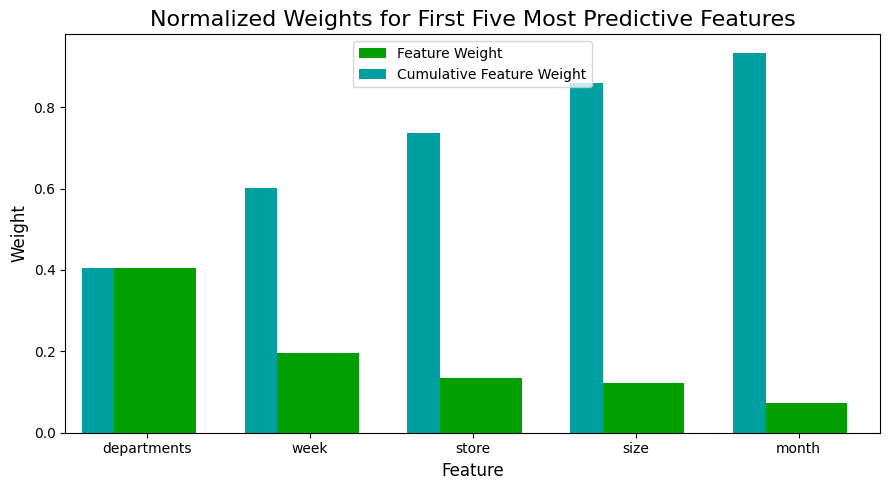

In [63]:
# Plot Most Important Features
importances_random = random_regr.feature_importances_ 

feature_plot(importances_random, X_train, y_train)

In [64]:
importances_random

array([0.13431646, 0.4058536 , 0.02239794, 0.12288697, 0.19573043,
       0.07370569, 0.04510891])

In [65]:
X_train.columns

Index(['store', 'departments', 'sale_type', 'size', 'week', 'month', 'year'], dtype='object')

Apply Robust Scaling to robust outliers with using median and IQR

In [66]:
#Call and fit model
scaler = RobustScaler()

pipeline = make_pipeline(scaler, random_regr)

pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate Erros
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s


Mean Squared Error (MSE): 284312456.00187033
Root Mean Squared Error (RMSE): 16861.567424230474


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Scaling does not affect our result we can move without it.

In [67]:
y_train_ravel = y_train.values.ravel()
y_test_ravel = y_test.values.ravel()

print('Shape of y_train',y_train_ravel.shape )
print('Shape of y_test', y_test_ravel.shape)

Shape of y_train (256867,)
Shape of y_test (110086,)


## Random Search on RandomForest Model

In [68]:
# Param Grid to Search 

param_dist = {
    'n_estimators': randint(100, 1000), 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': randint(10, 60),        
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20)  
}

# Call the model and fit the model
rf = RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)


random_search.fit(X_train, y_train_ravel)

#Get best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator
best_estimator = random_search.best_estimator_
# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

rmse = np.sqrt(mse)
print('RMSE:', rmse)

Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 136}
MSE: 282615960.0239476
RMSE: 16811.185562712333


Call our model with best parameters

In [69]:
# Call and fit the model - Random Search 
random_regr = RandomForestRegressor(max_depth=10, n_estimators=136, max_features='log2',min_samples_split= 6, min_samples_leaf= 12,random_state=42 ,n_jobs=-1, verbose=1)

random_regr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_regr.predict(X_test)

# Calculate Erros
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s


Mean Squared Error (MSE): 282532272.55698985
Root Mean Squared Error (RMSE): 16808.696337223475
R-squared: -0.0028695665523081892


[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


## Add new features such as holidays, CPI and Unemplyment 

In [137]:
df_extra_features = df.copy()

In [138]:
df_extra_features

,store,departments,date,weekly_sales,temperature,sale_type,size,week,month,year
0,1,12,2010-02-05,39334.454177,64.51,1,151315,5,2,2010
282589,29,67,2010-02-05,15892.350896,57.67,2,93638,5,2,2010
75472,8,87,2010-02-05,10474.579718,70.62,1,155078,5,2,2010
282440,29,48,2010-02-05,36743.967477,57.67,2,93638,5,2,2010
183243,19,84,2010-02-05,21281.329379,67.72,1,203819,5,2,2010
...,...,...,...,...,...,...,...,...,...,...
228155,24,83,2012-10-26,8437.171997,89.03,1,203819,43,10,2012
228012,24,26,2012-10-26,5606.978221,89.03,1,203819,43,10,2012
336330,35,96,2012-10-26,34273.739877,69.46,2,103681,43,10,2012
106136,11,3,2012-10-26,37139.696117,65.01,1,207499,43,10,2012


CSV files with CPI MoM , Unemplyment Rate MoM and Holidays included within our date range

In [139]:
df_new_features = pd.read_csv('data/holidays_cpi.csv', index_col=0)

In [140]:
df_new_features

,Holiday,CPI,Unemployment
Date,,,
05.02.2010,0,"216,74",9.8
05.02.2010,0,"216,74",9.8
05.02.2010,0,"216,74",9.8
05.02.2010,0,"216,74",9.8
05.02.2010,0,"216,74",9.8
...,...,...,...
26.10.2012,0,"230,70",7.8
26.10.2012,0,"230,70",7.8
26.10.2012,0,"230,70",7.8


In [141]:
df_new_features.reset_index(inplace=True)

In [142]:
df_new_features

,Date,Holiday,CPI,Unemployment
0,05.02.2010,0,"216,74",9.8
1,05.02.2010,0,"216,74",9.8
2,05.02.2010,0,"216,74",9.8
3,05.02.2010,0,"216,74",9.8
4,05.02.2010,0,"216,74",9.8
...,...,...,...,...
6430,26.10.2012,0,"230,70",7.8
6431,26.10.2012,0,"230,70",7.8
6432,26.10.2012,0,"230,70",7.8
6433,26.10.2012,0,"230,70",7.8


In [143]:
#Since other dataframes use lower case we changed each feature name to lowecase
cols = df_new_features.columns.tolist()
cols = [col.lower() for col in df_new_features.columns]
df_new_features.columns = cols 
df_new_features

,date,holiday,cpi,unemployment
0,05.02.2010,0,"216,74",9.8
1,05.02.2010,0,"216,74",9.8
2,05.02.2010,0,"216,74",9.8
3,05.02.2010,0,"216,74",9.8
4,05.02.2010,0,"216,74",9.8
...,...,...,...,...
6430,26.10.2012,0,"230,70",7.8
6431,26.10.2012,0,"230,70",7.8
6432,26.10.2012,0,"230,70",7.8
6433,26.10.2012,0,"230,70",7.8


In [144]:
df_new_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          6435 non-null   object 
 1   holiday       6435 non-null   int64  
 2   cpi           6435 non-null   object 
 3   unemployment  6435 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 201.2+ KB


In [145]:
# Replace commas with periods in the 'cpi' column
df_new_features['cpi'] = df_new_features['cpi'].str.replace(',', '.')

# Convert the 'cpi' column to float64
df_new_features['cpi'] = df_new_features['cpi'].astype('float64')


In [146]:
df_new_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          6435 non-null   object 
 1   holiday       6435 non-null   int64  
 2   cpi           6435 non-null   float64
 3   unemployment  6435 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 201.2+ KB


In [147]:
df_new_features['date'] = pd.to_datetime(df_new_features['date'], format='%d.%m.%Y')

In [148]:
df_new_features

,date,holiday,cpi,unemployment
0,2010-02-05,0,216.74,9.8
1,2010-02-05,0,216.74,9.8
2,2010-02-05,0,216.74,9.8
3,2010-02-05,0,216.74,9.8
4,2010-02-05,0,216.74,9.8
...,...,...,...,...
6430,2012-10-26,0,230.70,7.8
6431,2012-10-26,0,230.70,7.8
6432,2012-10-26,0,230.70,7.8
6433,2012-10-26,0,230.70,7.8


In [149]:
df_extra_features['date'].nunique()

143

In [150]:
df_new_features['date'].nunique()

143

In [151]:
df_extra_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366953 entries, 0 to 421569
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store         366953 non-null  int64         
 1   departments   366953 non-null  int64         
 2   date          366953 non-null  datetime64[ns]
 3   weekly_sales  366953 non-null  float64       
 4   temperature   366953 non-null  float64       
 5   sale_type     366953 non-null  int64         
 6   size          366953 non-null  int64         
 7   week          366953 non-null  int32         
 8   month         366953 non-null  int32         
 9   year          366953 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(4)
memory usage: 26.6 MB


In [152]:
df_new_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          6435 non-null   datetime64[ns]
 1   holiday       6435 non-null   int64         
 2   cpi           6435 non-null   float64       
 3   unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 201.2 KB


In [153]:
# Convert the date column to 'datetime64' format
df_new_features['date'] = pd.to_datetime(df_new_features['date'])

# Extract just the date part from the datetime column
df_new_features['date'] = df_new_features['date'].dt.date

In [154]:
df_new_features.drop_duplicates(subset=['date'], inplace=True)

In [155]:
# Convert the date column to 'datetime64' format
df_extra_features['date'] = pd.to_datetime(df_extra_features['date'])

# Extract just the date part from the datetime column
df_extra_features['date'] = df_extra_features['date'].dt.date

In [156]:
merge_features = pd.merge(df_extra_features, df_new_features, on='date', how='left')

In [157]:
merge_features

,store,departments,date,weekly_sales,temperature,sale_type,size,week,month,year,holiday,cpi,unemployment
0,1,12,2010-02-05,39334.454177,64.51,1,151315,5,2,2010,0,216.74,9.8
1,29,67,2010-02-05,15892.350896,57.67,2,93638,5,2,2010,0,216.74,9.8
2,8,87,2010-02-05,10474.579718,70.62,1,155078,5,2,2010,0,216.74,9.8
3,29,48,2010-02-05,36743.967477,57.67,2,93638,5,2,2010,0,216.74,9.8
4,19,84,2010-02-05,21281.329379,67.72,1,203819,5,2,2010,0,216.74,9.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366948,24,83,2012-10-26,8437.171997,89.03,1,203819,43,10,2012,0,230.70,7.8
366949,24,26,2012-10-26,5606.978221,89.03,1,203819,43,10,2012,0,230.70,7.8
366950,35,96,2012-10-26,34273.739877,69.46,2,103681,43,10,2012,0,230.70,7.8
366951,11,3,2012-10-26,37139.696117,65.01,1,207499,43,10,2012,0,230.70,7.8


In [158]:
merge_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366953 entries, 0 to 366952
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         366953 non-null  int64  
 1   departments   366953 non-null  int64  
 2   date          366953 non-null  object 
 3   weekly_sales  366953 non-null  float64
 4   temperature   366953 non-null  float64
 5   sale_type     366953 non-null  int64  
 6   size          366953 non-null  int64  
 7   week          366953 non-null  int32  
 8   month         366953 non-null  int32  
 9   year          366953 non-null  int32  
 10  holiday       366953 non-null  int64  
 11  cpi           366953 non-null  float64
 12  unemployment  366953 non-null  float64
dtypes: float64(4), int32(3), int64(5), object(1)
memory usage: 32.2+ MB


In [159]:
merge_features['holiday'] = merge_features['holiday'].astype(bool)

# EDA with New Features 

<Axes: xlabel='holiday', ylabel='weekly_sales'>

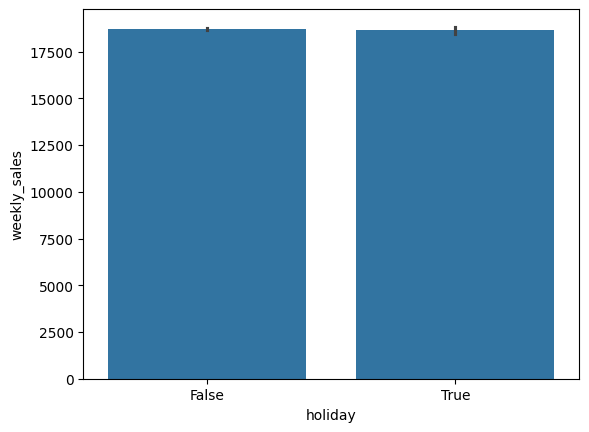

In [160]:
#Check for Holiday Affact
sns.barplot(x='holiday', y='weekly_sales', data=merge_features)

Seems like holiday does not affect on sales which does not make sense lets check our holiday data

In [161]:
df_holiday = merge_features.loc[merge_features['holiday']==1]
df_holiday['date'].unique() 

array([datetime.date(2010, 2, 12), datetime.date(2010, 9, 10),
       datetime.date(2010, 11, 26), datetime.date(2010, 12, 31),
       datetime.date(2011, 2, 11), datetime.date(2011, 9, 9),
       datetime.date(2011, 11, 25), datetime.date(2011, 12, 30),
       datetime.date(2012, 2, 10), datetime.date(2012, 9, 7)],
      dtype=object)

We can see that not all holidays are included.

Lets checked for which holidays can affact sales (https://www.timeanddate.com/holidays/us/2010?hol=33554809)

- Easter 04.04-05.04  
- Independence Day 04.07
- Halloween 31.09 

In [162]:
merge_features['date'] = pd.to_datetime(merge_features['date'], format='%d.%m.%Y')

In [163]:
merge_features['holiday'].value_counts()

holiday
False    341242
True      25711
Name: count, dtype: int64

In [164]:
#Set Easter Dates as True 
merge_features.loc[merge_features['date'].isin(['2010-04-02', '2011-04-01', '2012-03-30']), 'holiday'] = True

/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/2125941110.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  merge_features.loc[merge_features['date'].isin(['2010-04-02', '2011-04-01', '2012-03-30']), 'holiday'] = True


In [165]:
merge_features['holiday'].value_counts()

holiday
False    333495
True      33458
Name: count, dtype: int64

In [166]:
#Independence Day
merge_features.loc[merge_features['date'].isin(['2010-07-01', '2011-07-01', '2012-07-01']), 'holiday'] = True

/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/696190754.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  merge_features.loc[merge_features['date'].isin(['2010-07-01', '2011-07-01', '2012-07-01']), 'holiday'] = True


In [167]:
merge_features['holiday'].value_counts()

holiday
False    330936
True      36017
Name: count, dtype: int64

In [168]:
#Halloween
merge_features.loc[merge_features['date'].isin(['2010-09-30', '2011-09-30', '2012-09-30']), 'holiday'] = True

/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/40532817.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  merge_features.loc[merge_features['date'].isin(['2010-09-30', '2011-09-30', '2012-09-30']), 'holiday'] = True


In [169]:
merge_features['holiday'].value_counts()

holiday
False    328371
True      38582
Name: count, dtype: int64

In [170]:
#Christmas
merge_features.loc[merge_features['date'].isin(['2010-12-24', '2011-12-23']), 'holiday'] = True
merge_features['holiday'].value_counts()

/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/1741559212.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  merge_features.loc[merge_features['date'].isin(['2010-12-24', '2011-12-23']), 'holiday'] = True


holiday
False    323139
True      43814
Name: count, dtype: int64

In [171]:
#Thanksgiving
merge_features.loc[merge_features['date'].isin(['2010-11-19', '2011-11-18']), 'holiday'] = True
merge_features['holiday'].value_counts()

/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_38986/2671299174.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  merge_features.loc[merge_features['date'].isin(['2010-11-19', '2011-11-18']), 'holiday'] = True


holiday
False    318059
True      48894
Name: count, dtype: int64

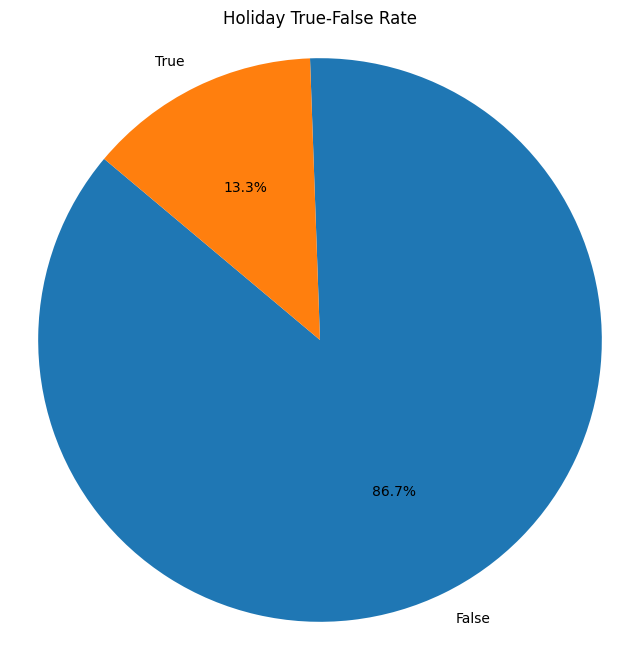

In [105]:
holiday_counts = merge_features['holiday'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(holiday_counts, labels=holiday_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Holiday True-False Rate')
plt.axis('equal')  
plt.show()

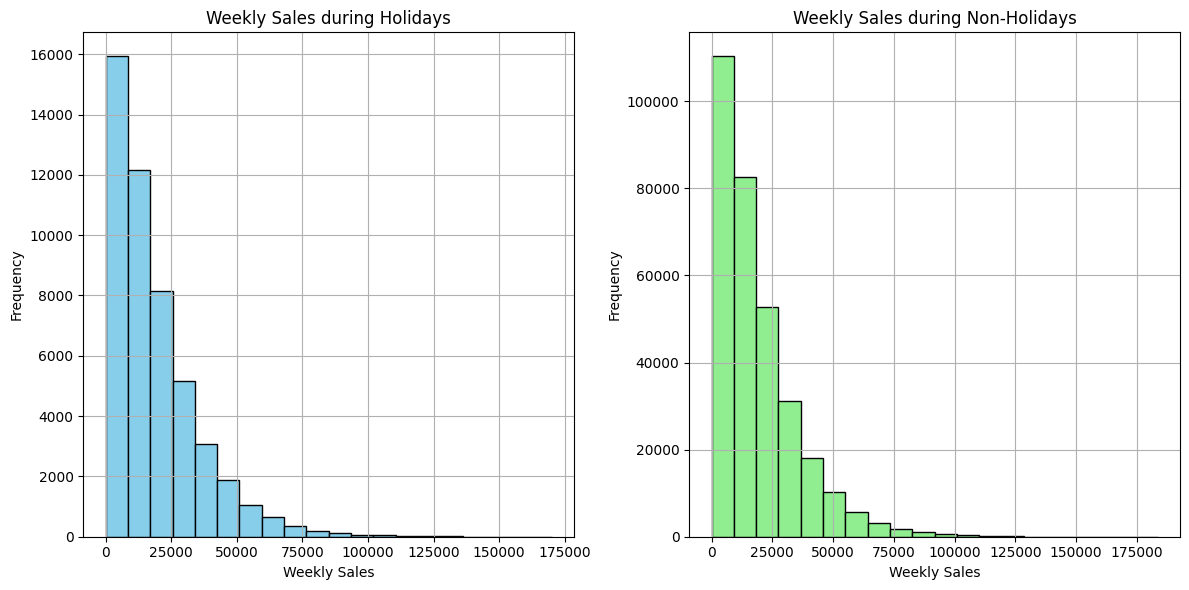

In [106]:
# Filter DataFrame for True and False holiday values
holiday_sales_true = merge_features[merge_features['holiday'] == True]
holiday_sales_false = merge_features[merge_features['holiday'] == False]

# Plotting the distribution of weekly_sales during holidays (True and False)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(holiday_sales_true['weekly_sales'], bins=20, color='skyblue', edgecolor='black')
plt.title('Weekly Sales during Holidays')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(holiday_sales_false['weekly_sales'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Weekly Sales during Non-Holidays')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

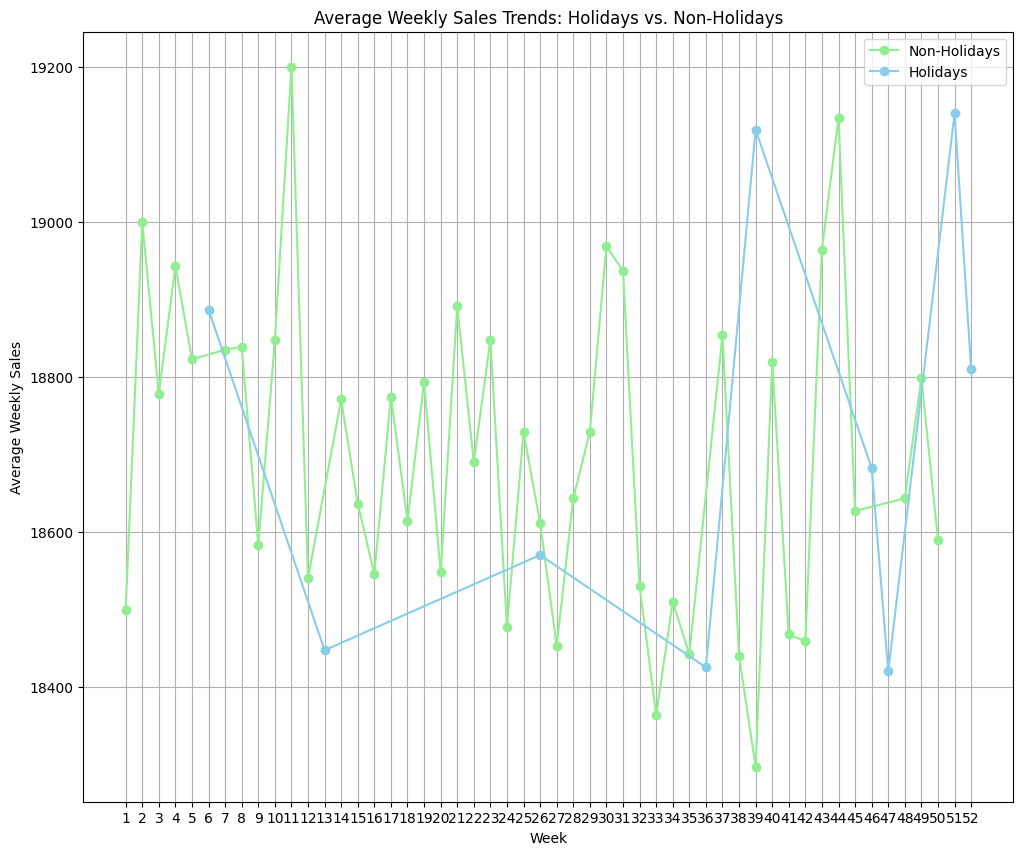

In [107]:
# Filter DataFrame for True and False holiday values
holiday_sales_true = merge_features[merge_features['holiday'] == True]
holiday_sales_false = merge_features[merge_features['holiday'] == False]

# Group by month and calculate mean weekly sales for both cases
holiday_sales_true_weekly = holiday_sales_true.groupby('week')['weekly_sales'].mean()
holiday_sales_false_weekly = holiday_sales_false.groupby('week')['weekly_sales'].mean()

# Plotting the line graphs
plt.figure(figsize=(12, 10))
plt.plot(holiday_sales_false_weekly.index, holiday_sales_false_weekly.values, marker='o', label='Non-Holidays', color='lightgreen')
plt.plot(holiday_sales_true_weekly.index, holiday_sales_true_weekly.values, marker='o', label='Holidays', color='skyblue')

plt.title('Average Weekly Sales Trends: Holidays vs. Non-Holidays')
plt.xlabel('Week')
plt.ylabel('Average Weekly Sales')
plt.xticks(range(1, 53))  # Assuming months are represented by integers from 1 to 12
plt.legend()
plt.grid(True)
plt.show()

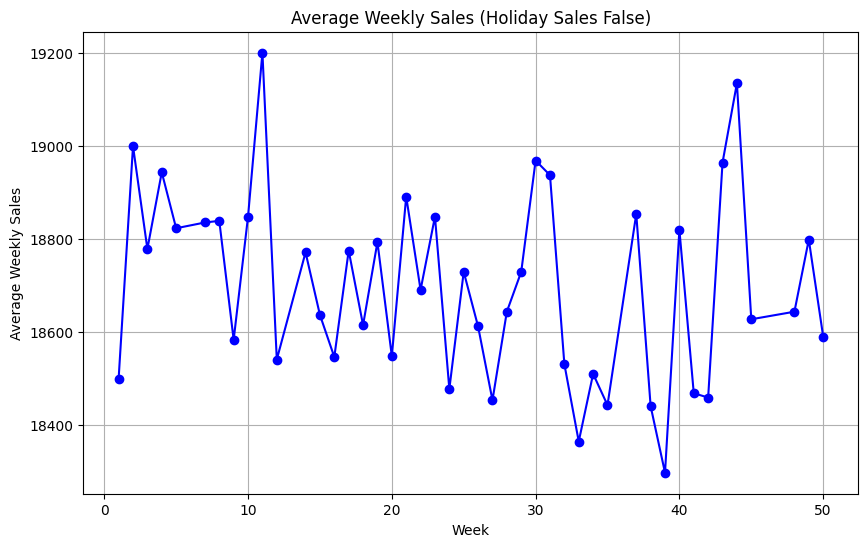

In [108]:
holiday_sales_false_monthly = holiday_sales_false.groupby('week')['weekly_sales'].mean()

plt.figure(figsize=(10, 6))  

holiday_sales_false_monthly.plot(kind='line', color='blue', marker='o', linestyle='-')

plt.title('Average Weekly Sales (Holiday Sales False)')
plt.xlabel('Week')
plt.ylabel('Average Weekly Sales')
plt.grid(True)
plt.show()

Even in the absence of holidays during the 11th week, the sales remain notably high, possibly attributed to strategic inventory management or pricing tactics implemented during specific periods.

<Axes: xlabel='cpi'>

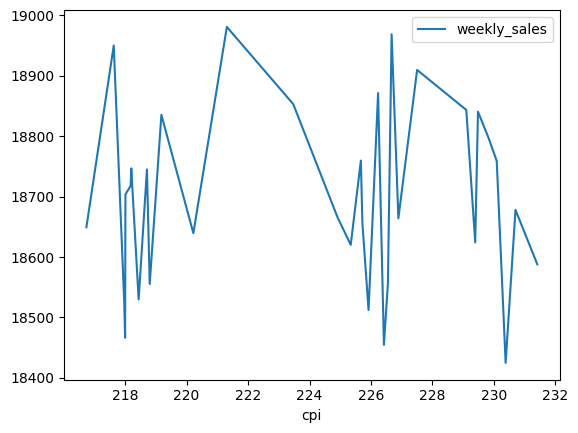

In [109]:
# Check CPI

CPI = pd.pivot_table(data=merge_features, values='weekly_sales', index='cpi')
CPI.plot()

<Axes: xlabel='unemployment'>

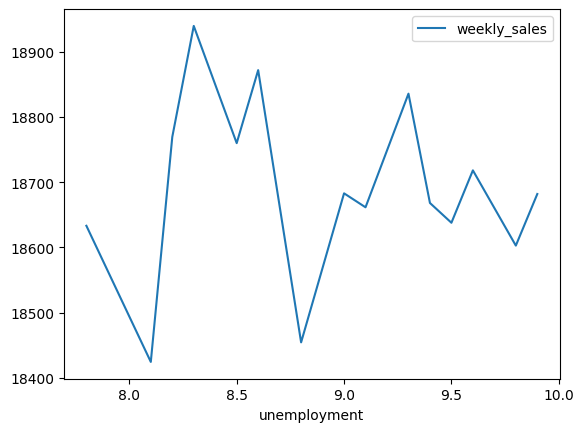

In [110]:
#Unemployment 
unemployment = pd.pivot_table(data=merge_features, values = "weekly_sales", index= "unemployment")
unemployment.plot()


# Model with New Features

In [231]:
lgbm_df = merge_features.copy()

In [111]:
merge_features= merge_features.drop(['date'], axis=1)

merge_features

,store,departments,weekly_sales,temperature,sale_type,size,week,month,year,holiday,cpi,unemployment
0,1,12,39334.454177,64.51,1,151315,5,2,2010,False,216.74,9.8
1,29,67,15892.350896,57.67,2,93638,5,2,2010,False,216.74,9.8
2,8,87,10474.579718,70.62,1,155078,5,2,2010,False,216.74,9.8
3,29,48,36743.967477,57.67,2,93638,5,2,2010,False,216.74,9.8
4,19,84,21281.329379,67.72,1,203819,5,2,2010,False,216.74,9.8
...,...,...,...,...,...,...,...,...,...,...,...,...
366948,24,83,8437.171997,89.03,1,203819,43,10,2012,False,230.70,7.8
366949,24,26,5606.978221,89.03,1,203819,43,10,2012,False,230.70,7.8
366950,35,96,34273.739877,69.46,2,103681,43,10,2012,False,230.70,7.8
366951,11,3,37139.696117,65.01,1,207499,43,10,2012,False,230.70,7.8


In [112]:
merge_features= merge_features.drop(['temperature'], axis=1)

merge_features

,store,departments,weekly_sales,sale_type,size,week,month,year,holiday,cpi,unemployment
0,1,12,39334.454177,1,151315,5,2,2010,False,216.74,9.8
1,29,67,15892.350896,2,93638,5,2,2010,False,216.74,9.8
2,8,87,10474.579718,1,155078,5,2,2010,False,216.74,9.8
3,29,48,36743.967477,2,93638,5,2,2010,False,216.74,9.8
4,19,84,21281.329379,1,203819,5,2,2010,False,216.74,9.8
...,...,...,...,...,...,...,...,...,...,...,...
366948,24,83,8437.171997,1,203819,43,10,2012,False,230.70,7.8
366949,24,26,5606.978221,1,203819,43,10,2012,False,230.70,7.8
366950,35,96,34273.739877,2,103681,43,10,2012,False,230.70,7.8
366951,11,3,37139.696117,1,207499,43,10,2012,False,230.70,7.8


In [113]:
train_df = merge_features.iloc[:int(0.7 * len(merge_features))]
test_df = merge_features.iloc[int(0.7 * len(merge_features)):]

target = ['weekly_sales']

features = [c for c in merge_features.columns.to_list() if c not in target]

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape )
print('Shape of y_train',y_train.shape )
print('Shape of y_test', y_test.shape)

Shape of X_train (256867, 10)
Shape of X_test (110086, 10)
Shape of y_train (256867, 1)
Shape of y_test (110086, 1)


## Random Forest

In [114]:
# Call and fit the model
random_regr = RandomForestRegressor(max_depth=10, n_estimators=100, max_features='sqrt',min_samples_split= 10,random_state=42 ,n_jobs=-1, verbose=1)

random_regr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_regr.predict(X_test)

# Calculate Erros
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s


Mean Squared Error (MSE): 286203313.59830546
Root Mean Squared Error (RMSE): 16917.544549913426


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


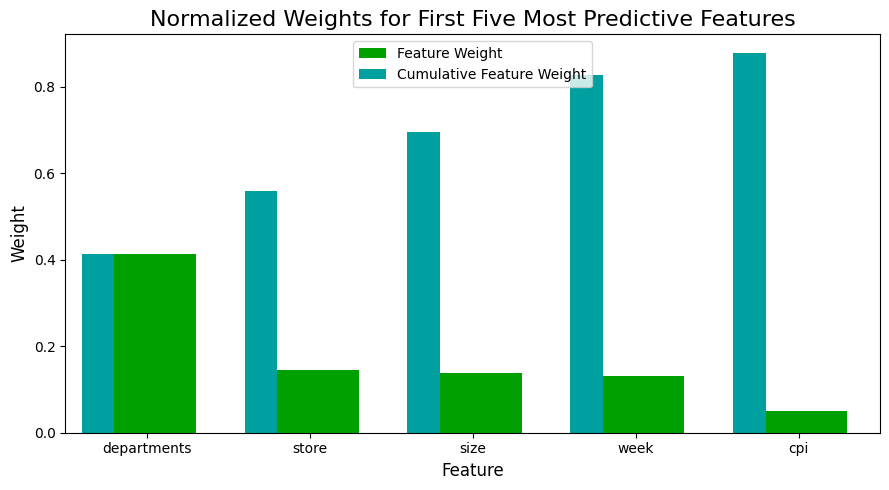

In [115]:
importances_random = random_regr.feature_importances_ 

feature_plot(importances_random, X_train, y_train)

In [116]:
y_train_ravel = y_train.values.ravel()
y_test_ravel = y_test.values.ravel()

print('Shape of y_train',y_train_ravel.shape )
print('Shape of y_test', y_test_ravel.shape)

Shape of y_train (256867,)
Shape of y_test (110086,)


Random Search

In [117]:
# Param Grid to Search 
param_dist = {
    'n_estimators': randint(100, 1000), 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': randint(10, 60),        
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20)  
}

# Call the model and fit the model
rf = RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)


random_search.fit(X_train, y_train_ravel)

#Get best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator
best_estimator = random_search.best_estimator_
# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

rmse = np.sqrt(mse)
print('RMSE:', rmse)

Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 136}
MSE: 283868606.63640136
RMSE: 16848.400714501106


In [118]:
# Call and fit the model
random_regr = RandomForestRegressor(max_depth=10, n_estimators=136, max_features='log2',min_samples_split= 6, min_samples_leaf=12,random_state=42 ,n_jobs=-1, verbose=1)

random_regr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_regr.predict(X_test)

# Calculate Erros
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s


Mean Squared Error (MSE): 283160789.17748916
Root Mean Squared Error (RMSE): 16827.382124902528


[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


In [119]:
importances = random_regr.feature_importances_
feature_importances = pd.DataFrame(random_regr.feature_importances_, index = X_train.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance',ascending=False)

,Importance
departments,0.360476
store,0.151577
week,0.149743
size,0.148113
cpi,0.057538
month,0.039561
unemployment,0.037738
sale_type,0.025787
holiday,0.018619
year,0.010849


Let's drop Year and Month 

In [120]:
df_ym_drop= merge_features.drop(['year','month'], axis=1)

df_ym_drop

,store,departments,weekly_sales,sale_type,size,week,holiday,cpi,unemployment
0,1,12,39334.454177,1,151315,5,False,216.74,9.8
1,29,67,15892.350896,2,93638,5,False,216.74,9.8
2,8,87,10474.579718,1,155078,5,False,216.74,9.8
3,29,48,36743.967477,2,93638,5,False,216.74,9.8
4,19,84,21281.329379,1,203819,5,False,216.74,9.8
...,...,...,...,...,...,...,...,...,...
366948,24,83,8437.171997,1,203819,43,False,230.70,7.8
366949,24,26,5606.978221,1,203819,43,False,230.70,7.8
366950,35,96,34273.739877,2,103681,43,False,230.70,7.8
366951,11,3,37139.696117,1,207499,43,False,230.70,7.8


In [121]:
df_ym_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366953 entries, 0 to 366952
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         366953 non-null  int64  
 1   departments   366953 non-null  int64  
 2   weekly_sales  366953 non-null  float64
 3   sale_type     366953 non-null  int64  
 4   size          366953 non-null  int64  
 5   week          366953 non-null  int32  
 6   holiday       366953 non-null  bool   
 7   cpi           366953 non-null  float64
 8   unemployment  366953 non-null  float64
dtypes: bool(1), float64(3), int32(1), int64(4)
memory usage: 21.3 MB


Change dtype of categorical data 

In [122]:
df_ym_drop['store'] = df_ym_drop['store'].astype('category')
df_ym_drop['departments'] = df_ym_drop['departments'].astype('category')
df_ym_drop['sale_type'] = df_ym_drop['sale_type'].astype('category')

In [123]:
train_df = df_ym_drop.iloc[:int(0.7 * len(df_ym_drop))]
test_df = df_ym_drop.iloc[int(0.7 * len(df_ym_drop)):]

target = ['weekly_sales']

features = [c for c in df_ym_drop.columns.to_list() if c not in target]

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape )
print('Shape of y_train',y_train.shape )
print('Shape of y_test', y_test.shape)

y_train_ravel = y_train.values.ravel()
y_test_ravel = y_test.values.ravel()

print('Shape of y_train',y_train_ravel.shape )
print('Shape of y_test', y_test_ravel.shape)

Shape of X_train (256867, 8)
Shape of X_test (110086, 8)
Shape of y_train (256867, 1)
Shape of y_test (110086, 1)
Shape of y_train (256867,)
Shape of y_test (110086,)


In [124]:
# Call and fit the model
random_regr = RandomForestRegressor(max_depth=10, n_estimators=136, max_features='log2',min_samples_split= 6, min_samples_leaf=12,random_state=42 ,n_jobs=-1, verbose=1)

random_regr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_regr.predict(X_test)

# Calculate Erros
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.2s finished


Mean Squared Error (MSE): 283041081.71927184
Root Mean Squared Error (RMSE): 16823.824824316016


In [125]:
importances = random_regr.feature_importances_
feature_importances = pd.DataFrame(random_regr.feature_importances_, index = X_train.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance',ascending=False)

,Importance
departments,0.344938
week,0.180151
store,0.149583
size,0.141263
cpi,0.082805
unemployment,0.054727
sale_type,0.024283
holiday,0.022250


Drop CPI, unemployment and sale_type since size already giving information about that 

In [126]:
df_importance_f = merge_features.drop(['cpi','unemployment', 'sale_type','year'], axis=1)

df_importance_f

,store,departments,weekly_sales,size,week,month,holiday
0,1,12,39334.454177,151315,5,2,False
1,29,67,15892.350896,93638,5,2,False
2,8,87,10474.579718,155078,5,2,False
3,29,48,36743.967477,93638,5,2,False
4,19,84,21281.329379,203819,5,2,False
...,...,...,...,...,...,...,...
366948,24,83,8437.171997,203819,43,10,False
366949,24,26,5606.978221,203819,43,10,False
366950,35,96,34273.739877,103681,43,10,False
366951,11,3,37139.696117,207499,43,10,False


In [286]:
train_df = df_importance_f.iloc[:int(0.7 * len(df_importance_f))]
test_df = df_importance_f.iloc[int(0.7 * len(df_importance_f)):]

target = ['weekly_sales']

features = [c for c in df_importance_f.columns.to_list() if c not in target]

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape )
print('Shape of y_train',y_train.shape )
print('Shape of y_test', y_test.shape)

y_train_ravel = y_train.values.ravel()
y_test_ravel = y_test.values.ravel()

print('Shape of y_train',y_train_ravel.shape )
print('Shape of y_test', y_test_ravel.shape)

Shape of X_train (256867, 5)
Shape of X_test (110086, 5)
Shape of y_train (256867, 1)
Shape of y_test (110086, 1)
Shape of y_train (256867,)
Shape of y_test (110086,)


In [128]:
# Call and fit the model
random_regr = RandomForestRegressor(max_depth=10, n_estimators=136, max_features='log2',min_samples_split= 6, min_samples_leaf=12,random_state=42 ,n_jobs=-1, verbose=1)

random_regr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_regr.predict(X_test)

# Calculate Erros
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s


Mean Squared Error (MSE): 281670458.9883966
Root Mean Squared Error (RMSE): 16783.04081471521


[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.2s finished


In [129]:
importances = random_regr.feature_importances_
feature_importances = pd.DataFrame(random_regr.feature_importances_, index = X_train.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance',ascending=False)

,Importance
departments,0.412060
week,0.186212
store,0.158351
size,0.151366
month,0.070890
holiday,0.021121


In [130]:
# Param Grid to Search 
param_dist = {
    'n_estimators': randint(100, 1000), 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': randint(10, 60),        
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20)  
}

# Call the model and fit the model
rf = RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)


random_search.fit(X_train, y_train_ravel)

#Get best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator
best_estimator = random_search.best_estimator_
# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

rmse = np.sqrt(mse)
print('RMSE:', rmse)

Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 136}
MSE: 281663939.86894774
RMSE: 16782.846596121522


Lets drop month too

In [131]:
df_importance_f = df_importance_f.drop(['month'], axis=1)

df_importance_f

,store,departments,weekly_sales,size,week,holiday
0,1,12,39334.454177,151315,5,False
1,29,67,15892.350896,93638,5,False
2,8,87,10474.579718,155078,5,False
3,29,48,36743.967477,93638,5,False
4,19,84,21281.329379,203819,5,False
...,...,...,...,...,...,...
366948,24,83,8437.171997,203819,43,False
366949,24,26,5606.978221,203819,43,False
366950,35,96,34273.739877,103681,43,False
366951,11,3,37139.696117,207499,43,False


In [285]:
df_importance_f

,store,departments,weekly_sales,size,week,holiday
0,1,12,39334.454177,151315,5,False
1,29,67,15892.350896,93638,5,False
2,8,87,10474.579718,155078,5,False
3,29,48,36743.967477,93638,5,False
4,19,84,21281.329379,203819,5,False
...,...,...,...,...,...,...
366948,24,83,8437.171997,203819,43,False
366949,24,26,5606.978221,203819,43,False
366950,35,96,34273.739877,103681,43,False
366951,11,3,37139.696117,207499,43,False


In [132]:
train_df = df_importance_f.iloc[:int(0.7 * len(df_importance_f))]
test_df = df_importance_f.iloc[int(0.7 * len(df_importance_f)):]

target = ['weekly_sales']

features = [c for c in df_importance_f.columns.to_list() if c not in target]

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape )
print('Shape of y_train',y_train.shape )
print('Shape of y_test', y_test.shape)

y_train_ravel = y_train.values.ravel()
y_test_ravel = y_test.values.ravel()

print('Shape of y_train',y_train_ravel.shape )
print('Shape of y_test', y_test_ravel.shape)

Shape of X_train (256867, 5)
Shape of X_test (110086, 5)
Shape of y_train (256867, 1)
Shape of y_test (110086, 1)
Shape of y_train (256867,)
Shape of y_test (110086,)


In [133]:
# Call and fit the model
random_regr = RandomForestRegressor(max_depth=10, n_estimators=136, max_features='log2',min_samples_split= 6, min_samples_leaf=12,random_state=42 ,n_jobs=-1, verbose=1)

random_regr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_regr.predict(X_test)

# Calculate Erros
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

importances = random_regr.feature_importances_
feature_importances = pd.DataFrame(random_regr.feature_importances_, index = X_train.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance',ascending=False)


/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Mean Squared Error (MSE): 281637929.1575209
Root Mean Squared Error (RMSE): 16782.071658693418


[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.2s finished


,Importance
departments,0.405149
week,0.281328
store,0.149653
size,0.138847
holiday,0.025023


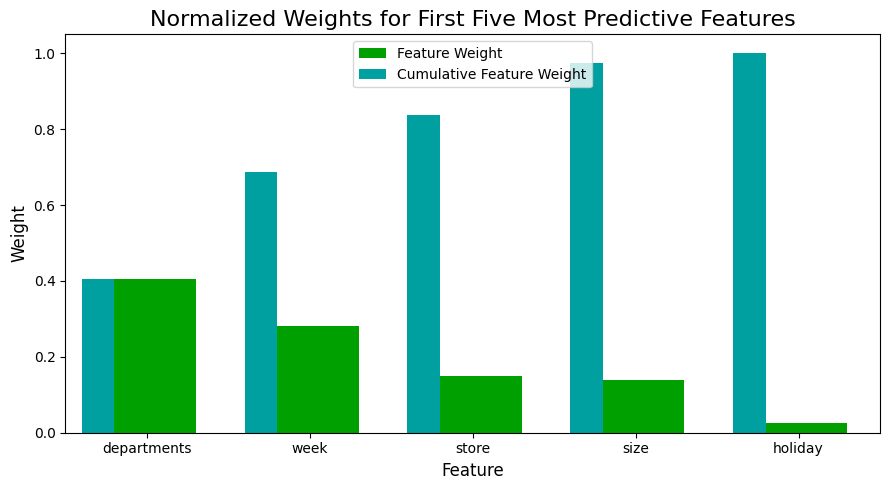

In [287]:
importances_random = random_regr.feature_importances_ 

feature_plot(importances_random, X_train, y_train)

In [134]:
# Param Grid to Search 
param_dist = {
    'n_estimators': randint(100, 1000), 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': randint(10, 60),        
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20)  
}

# Call the model and fit the model
rf = RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)


random_search.fit(X_train, y_train_ravel)

#Get best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator
best_estimator = random_search.best_estimator_
# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

rmse = np.sqrt(mse)
print('RMSE:', rmse)

Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 136}
MSE: 281669806.0674077
RMSE: 16783.02136289553


## LightGBM [Light Gradient Boosting Machine]

In [289]:
lgbm_df

,store,departments,date,weekly_sales,temperature,sale_type,size,week,month,year,holiday,cpi,unemployment
0,1,12,2010-02-05,39334.454177,64.51,1,151315,5,2,2010,False,216.74,9.8
1,29,67,2010-02-05,15892.350896,57.67,2,93638,5,2,2010,False,216.74,9.8
2,8,87,2010-02-05,10474.579718,70.62,1,155078,5,2,2010,False,216.74,9.8
3,29,48,2010-02-05,36743.967477,57.67,2,93638,5,2,2010,False,216.74,9.8
4,19,84,2010-02-05,21281.329379,67.72,1,203819,5,2,2010,False,216.74,9.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366948,24,83,2012-10-26,8437.171997,89.03,1,203819,43,10,2012,False,230.70,7.8
366949,24,26,2012-10-26,5606.978221,89.03,1,203819,43,10,2012,False,230.70,7.8
366950,35,96,2012-10-26,34273.739877,69.46,2,103681,43,10,2012,False,230.70,7.8
366951,11,3,2012-10-26,37139.696117,65.01,1,207499,43,10,2012,False,230.70,7.8


Modeling

In [290]:
#Train-Test-Val Split (Time-Series Split)

train_size = int(len(lgbm_df) * 0.7)
val_size = int(len(lgbm_df) * 0.15)

train_data = lgbm_df[:train_size]
val_data = lgbm_df[train_size:train_size + val_size]
test_data = lgbm_df[train_size + val_size:]

X_train, y_train = train_data.drop(['weekly_sales', 'date'], axis=1), train_data['weekly_sales']
X_val, y_val = val_data.drop(['weekly_sales', 'date'], axis=1), val_data['weekly_sales']
X_test, y_test = test_data.drop(['weekly_sales', 'date'], axis=1), test_data['weekly_sales']

#Model Training
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

num_round = 1000
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_val], callbacks=[
        lgb.early_stopping(stopping_rounds=10),], valid_names=['train', 'val'])

#Evaluation
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration or 1000)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error on Test Set:', mse)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	train's rmse: 16725.4	val's rmse: 16872
Mean Squared Error on Test Set: 278822512.5059535


In [257]:
np.sqrt(mse)

16697.97929409285

Grid Search with LGBM

In [258]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 30, 40],
    'feature_fraction': [0.5, 0.7, 1.0],
    'bagging_fraction': [0.5, 0.7, 1.0],
    'bagging_freq': [1, 5, 10]
}

#Initialize GridSearchCV
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', verbose=-1)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')

grid_search.fit(X_train, y_train)

#Best Hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

python(61230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Hyperparameters: {'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 1.0, 'learning_rate': 0.01, 'num_leaves': 20}


Call model with best params 

In [291]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 20,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'verbose': 0
}

num_round = 1000
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_val], callbacks=[
        lgb.early_stopping(stopping_rounds=10),], valid_names=['train', 'val'])

#Evaluation
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration or 1000)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error on Test Set:', mse)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	train's rmse: 16718.4	val's rmse: 16868.2
Mean Squared Error on Test Set: 278706454.5987114
RMSE: 16694.50372424144


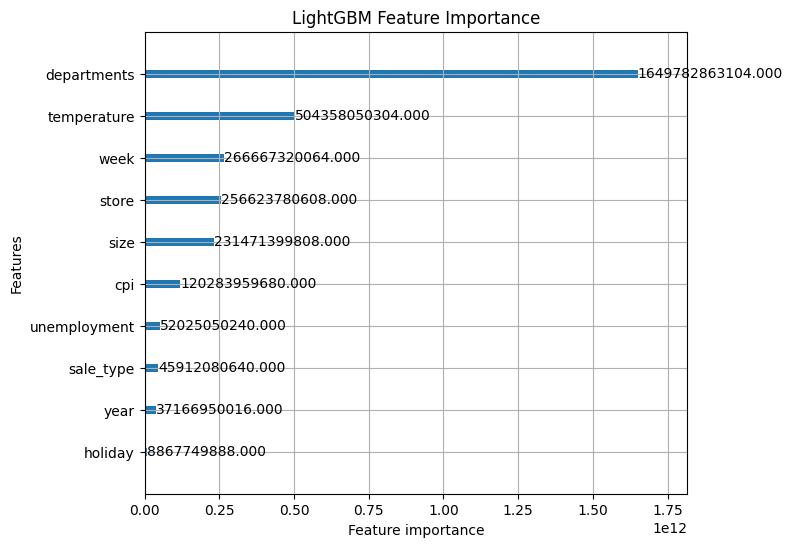

In [297]:
lgb.plot_importance(bst, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance")
plt.show()

### Last let's just use features from best result in Random Forest with Best Result

In [262]:
lgmb_reduced = lgbm_df.copy()

In [266]:
lgmb_reduced.drop(['date','temperature', 'sale_type','month','year','unemployment'], axis=1, inplace=True)

lgmb_reduced

,store,departments,weekly_sales,size,week,holiday,cpi
0,1,12,39334.454177,151315,5,False,216.74
1,29,67,15892.350896,93638,5,False,216.74
2,8,87,10474.579718,155078,5,False,216.74
3,29,48,36743.967477,93638,5,False,216.74
4,19,84,21281.329379,203819,5,False,216.74
...,...,...,...,...,...,...,...
366948,24,83,8437.171997,203819,43,False,230.70
366949,24,26,5606.978221,203819,43,False,230.70
366950,35,96,34273.739877,103681,43,False,230.70
366951,11,3,37139.696117,207499,43,False,230.70


In [298]:
lgmb_reduced

,store,departments,weekly_sales,size,week,holiday,cpi
0,1,12,39334.454177,151315,5,False,216.74
1,29,67,15892.350896,93638,5,False,216.74
2,8,87,10474.579718,155078,5,False,216.74
3,29,48,36743.967477,93638,5,False,216.74
4,19,84,21281.329379,203819,5,False,216.74
...,...,...,...,...,...,...,...
366948,24,83,8437.171997,203819,43,False,230.70
366949,24,26,5606.978221,203819,43,False,230.70
366950,35,96,34273.739877,103681,43,False,230.70
366951,11,3,37139.696117,207499,43,False,230.70


In [304]:
#Train-Test-Val Split (Time-Series Split)

train_size = int(len(lgmb_reduced) * 0.7)
val_size = int(len(lgmb_reduced) * 0.15)

train_data = lgmb_reduced[:train_size]
val_data = lgmb_reduced[train_size:train_size + val_size]
test_data = lgmb_reduced[train_size + val_size:]

X_train, y_train = train_data.drop(['weekly_sales'], axis=1), train_data['weekly_sales']
X_val, y_val = val_data.drop(['weekly_sales'], axis=1), val_data['weekly_sales']
X_test, y_test = test_data.drop(['weekly_sales'], axis=1), test_data['weekly_sales']

In [305]:
#Model Training
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

num_round = 1000
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_val], callbacks=[
        lgb.early_stopping(stopping_rounds=10),], valid_names=['train', 'val'])

#Evaluation
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration or 1000)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)
rmse = np.sqrt(mse)
print('RMSE:',rmse)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	train's rmse: 16711.1	val's rmse: 16868
MSE: 278638766.49056953
RMSE: 16692.476343867304


In [306]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [10,20, 30, 40,70],
    'feature_fraction': [0.5, 0.7, 1.0],
    'bagging_fraction': [0.5, 0.7, 1.0],
    'bagging_freq': [1, 5, 10],
    'colsample_bytree': [0.3,0.5,0.7,1],
    'n_estimators': [50, 100, 300, 500]

}

#Initialize GridSearchCV
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', verbose=-1)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')

grid_search.fit(X_train, y_train)

#Best Hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

KeyboardInterrupt: 

In [307]:
#Call the model with best hyperparameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 10,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'colsample_bytree': 0.3,
    'n_estimators': 100,
    'verbose': 0
}

num_round = 1000
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_val], callbacks=[
        lgb.early_stopping(stopping_rounds=10),], valid_names=['train', 'val'])

#Evaluation
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration or 1000)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)
rmse = np.sqrt(mse)
print('RMSE:',rmse)

/Users/burakbedir/Desktop/Leveragai/Retail Demand Forecast/Retail-Demand-Foreceast/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=1
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 16717.4	val's rmse: 16865.8
MSE: 278581368.2677997
RMSE: 16690.756971084316


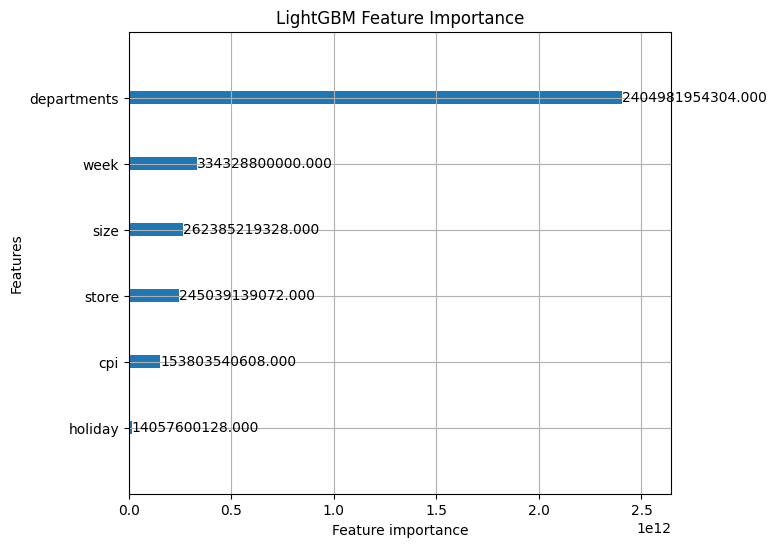

In [308]:
lgb.plot_importance(bst, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance")
plt.show()

In [283]:
#Create DF for our results

df_results = pd.DataFrame(columns=["Model", "Info",'RMSE']) 


rows = [
    {"Model": 'RandomForestRegressor', "Info": 'All Base Features', 'RMSE': 16862},
    {"Model": 'RandomForestRegressor', "Info": 'All Base Features - Random Search', 'RMSE': 16811},
    {"Model": 'RandomForestRegressor', "Info": 'New Features', 'RMSE': 16917},
    {"Model": 'RandomForestRegressor', "Info": 'New Features - Random Search', 'RMSE': 16827},
    {"Model": 'RandomForestRegressor', "Info": 'Feature Engineering - Random Search', 'RMSE': 16782},
    {"Model": 'LightGBM', "Info": 'All Features', 'RMSE': 16697},
    {"Model": 'LightGBM', "Info": 'All Features - Random Search', 'RMSE': 16694},
    {"Model": 'LightGBM', "Info": 'Feature Engineering - Random Search', 'RMSE': 16690}
]


df_results = pd.concat([df_results, pd.DataFrame(rows)], ignore_index=True)


In [284]:
df_results

,Model,Info,RMSE
0,RandomForestRegressor,All Base Features,16862
1,RandomForestRegressor,All Base Features - Random Search,16811
2,RandomForestRegressor,New Features,16917
3,RandomForestRegressor,New Features - Random Search,16827
4,RandomForestRegressor,Feature Engineering - Random Search,16782
5,LightGBM,All Features,16697
6,LightGBM,All Features - Random Search,16694
7,LightGBM,Feature Engineering - Random Search,16690


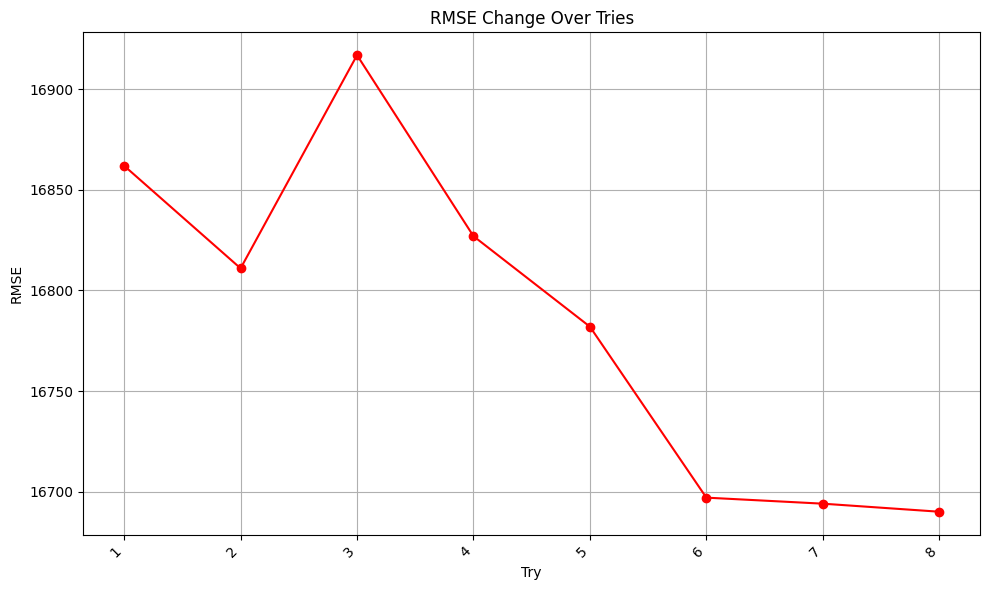

In [314]:
tries = [1,2,3,4,5,6,7,8]
rmse = [16862, 16811, 16917, 16827, 16782, 16697, 16694, 16690]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(tries, rmse, marker='o', linestyle='-', color='r')
plt.title('RMSE Change Over Tries')
plt.xlabel('Try')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()